<a target="_blank" href="https://colab.research.google.com/github/SidSaxena01/Genre-Classification">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Lab 3: Music Genre Classification
    By Siddharth Saxena & Andreas Papaeracleous

# Music Genre Classification - Task 1
Using Essentia descriptors with ARFF files

In [1]:

# Import necessary libraries
import time
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.io import arff
from sklearn.decomposition import PCA
from sklearn.ensemble import (
    GradientBoostingClassifier,
    RandomForestClassifier,
    VotingClassifier,
)
from sklearn.feature_selection import RFE, SelectKBest, f_classif, mutual_info_classif
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import (
    GridSearchCV,
    StratifiedKFold,
    cross_val_score,
    train_test_split,
)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

warnings.filterwarnings('ignore')

### 1. Data Loading and Exploration


In [2]:

print("Loading ARFF files...")

# Function to load ARFF files
def load_arff(file_path):
    data, meta = arff.loadarff(file_path)
    df = pd.DataFrame(data)
    # Convert bytes to string for categorical variables
    for col in df.select_dtypes([object]).columns:
        df[col] = df[col].str.decode('utf-8')
    return df

# Define data paths
data_folder = 'data'
genre_folder = 'Genre-TrainTestPap'

# Load training and testing data
train_file = f'{data_folder}/{genre_folder}/GenreTrain.arff'
test_file = f'{data_folder}/{genre_folder}/GenreTest.arff'

train_df = load_arff(train_file)
test_df = load_arff(test_file)

print("Data loaded successfully!")
print(f"Training data shape: {train_df.shape}")
print(f"Testing data shape: {test_df.shape}")

Loading ARFF files...
Data loaded successfully!
Training data shape: (800, 241)
Testing data shape: (193, 241)


In [3]:
train_df.describe()

,highlevel_danceability_value,highlevel_equalization_profile_value,highlevel_excitement_value,highlevel_intensity_value,loudness_dynamic_complexity_dvar,loudness_dynamic_complexity_mean,loudness_dynamic_complexity_var,loudness_larm_dvar,loudness_larm_mean,loudness_larm_var,...,tonal_chords_dissonance_var,tonal_chords_number_rate_value,tonal_chords_strength_dvar,tonal_chords_strength_mean,tonal_chords_strength_var,tonal_dissonance_dvar,tonal_dissonance_mean,tonal_dissonance_var,tonal_key_strength_value,tonal_tuning_equal_tempered_deviation_value
count,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,...,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000
mean,-0.008828,0.012008,-0.000453,-0.007498,-0.005019,-0.002292,-0.006915,0.009416,-0.013217,0.007484,...,-0.006921,-0.005009,0.019343,0.011332,-0.002560,-0.016522,0.010915,-0.001289,0.007371,0.019586
std,0.993652,0.992688,1.000056,1.003152,0.996671,1.002032,1.004539,1.055748,1.005173,1.064159,...,1.015714,1.020164,1.105611,1.006659,0.986915,0.991877,0.997895,1.012360,1.011383,1.021517
min,-1.749979,-1.940715,-1.283803,-2.033312,-1.532154,-2.358412,-1.920794,-0.866527,-4.300282,-0.549756,...,-0.851204,-1.792939,-0.467352,-3.693614,-1.833390,-1.570727,-3.898309,-1.360556,-3.888748,-1.257169
25%,-0.682106,0.372766,-1.283803,-0.615420,-0.528539,-0.644939,-0.380457,-0.471602,-0.486220,-0.297066,...,-0.609641,-0.636402,-0.253960,-0.675153,-0.690376,-0.660168,-0.503737,-0.707110,-0.580296,-0.724222
50%,-0.156135,0.372766,0.029087,0.093526,-0.138860,-0.070734,-0.035377,-0.215749,0.134099,-0.217527,...,-0.357305,-0.247911,-0.123309,0.025173,-0.153054,-0.182309,0.274808,-0.189852,0.142348,-0.225246
75%,0.489871,0.372766,1.341977,0.802473,0.242988,0.520698,0.255724,0.185487,0.591432,-0.038464,...,0.125424,0.520134,0.083342,0.661001,0.511474,0.499269,0.707486,0.473746,0.770136,0.436499
max,7.754278,1.529507,1.341977,2.929312,8.877894,5.779127,6.720551,22.199275,3.042905,25.411209,...,7.826706,4.375254,29.521946,2.776634,8.522866,5.058133,1.583319,5.060315,1.658376,4.236572


In [4]:

# Explore the training data
print("\nExploring training data:")
print("Classes distribution:")
print(train_df['genre'].value_counts())
print("\nFeature statistics:")
print(train_df.describe().T)


Exploring training data:
Classes distribution:
genre
blu    80
cla    80
cou    80
dis    80
hip    80
jaz    80
met    80
pop    80
reg    80
roc    80
Name: count, dtype: int64

Feature statistics:
                                             count      mean       std  \
highlevel_danceability_value                 800.0 -0.008828  0.993652   
highlevel_equalization_profile_value         800.0  0.012008  0.992688   
highlevel_excitement_value                   800.0 -0.000453  1.000056   
highlevel_intensity_value                    800.0 -0.007498  1.003152   
loudness_dynamic_complexity_dvar             800.0 -0.005019  0.996671   
...                                            ...       ...       ...   
tonal_dissonance_dvar                        800.0 -0.016522  0.991877   
tonal_dissonance_mean                        800.0  0.010915  0.997895   
tonal_dissonance_var                         800.0 -0.001289  1.012360   
tonal_key_strength_value                     800.0  0.00737

In [5]:

# Check for missing values
print("\nChecking for missing values:")
print(train_df.isnull().sum().sum())


Checking for missing values:
0


### 2. Data Preprocessing


In [6]:
print("\nPreprocessing data...")

# Extract features and target
X_train = train_df.drop('genre', axis=1)
y_train = train_df['genre']
X_test = test_df.drop('genre', axis=1)
y_test = test_df['genre']

# Inspect data types
print("\nInspecting feature data types:")
print(X_train.dtypes.value_counts())

# Handle categorical columns with one-hot encoding
categorical_cols = X_train.select_dtypes(include=['object']).columns.tolist()
if categorical_cols:
    print(f"\nFound categorical columns: {categorical_cols}")
    
    # Display values for all categorical columns
    for col in categorical_cols:
        print(f"\nValues in {col}:")
        print(X_train[col].value_counts())
    
    # Apply one-hot encoding to categorical columns    
    # Get numerical features
    numerical_cols = X_train.select_dtypes(exclude=['object']).columns.tolist()
    numerical_data_train = X_train[numerical_cols]
    numerical_data_test = X_test[numerical_cols]
    
    # Encode categorical features
    encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    categorical_data_train = encoder.fit_transform(X_train[categorical_cols])
    categorical_data_test = encoder.transform(X_test[categorical_cols])
    
    # Get encoded feature names for later use
    encoded_feature_names = []
    for i, col in enumerate(categorical_cols):
        values = encoder.categories_[i]
        for val in values:
            encoded_feature_names.append(f"{col}_{val}")
    
    print(f"\nEncoded {len(categorical_cols)} categorical columns into {len(encoded_feature_names)} binary features")
    
    # Convert to numpy arrays for combining
    X_train_numerical = numerical_data_train.values
    X_test_numerical = numerical_data_test.values
    
    # Combine numerical and one-hot encoded features
    X_train_combined = np.hstack((X_train_numerical, categorical_data_train))
    X_test_combined = np.hstack((X_test_numerical, categorical_data_test))
    
    # Create new feature names list (for later feature importance)
    feature_names = numerical_cols + encoded_feature_names
    print(f"Combined feature matrix shape: {X_train_combined.shape}")
else:
    X_train_combined = X_train.values
    X_test_combined = X_test.values
    feature_names = X_train.columns.tolist()

# Encode target variable
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)
print(f"Genres: {label_encoder.classes_}")
print(f"Training samples per genre: {np.bincount(y_train_encoded)}")

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_combined)
X_test_scaled = scaler.transform(X_test_combined)


Preprocessing data...

Inspecting feature data types:
float64    237
object       3
Name: count, dtype: int64

Found categorical columns: ['highlevel_speech_music_value', 'highlevel_voice_instrumental_value', 'tonal_key_mode_value']

Values in highlevel_speech_music_value:
highlevel_speech_music_value
music     591
speech    209
Name: count, dtype: int64

Values in highlevel_voice_instrumental_value:
highlevel_voice_instrumental_value
voice           458
instrumental    342
Name: count, dtype: int64

Values in tonal_key_mode_value:
tonal_key_mode_value
major    561
minor    239
Name: count, dtype: int64

Encoded 3 categorical columns into 6 binary features
Combined feature matrix shape: (800, 243)
Genres: ['blu' 'cla' 'cou' 'dis' 'hip' 'jaz' 'met' 'pop' 'reg' 'roc']
Training samples per genre: [80 80 80 80 80 80 80 80 80 80]


### 3. Feature Selection and Dimensionality Reduction

In [7]:
print("\nPerforming feature selection...")

# Univariate feature selection
def select_features(X, y, k=20):
    selector = SelectKBest(score_func=f_classif, k=k)
    selector.fit(X, y)
    
    # Get feature importance scores
    scores = selector.scores_
    
    # If feature_names are available, use them for better reporting
    selected_indices = selector.get_support(indices=True)
    if 'feature_names' in locals() or 'feature_names' in globals():
        selected_features = [feature_names[i] for i in selected_indices]
    else:
        selected_features = [f"feature_{i}" for i in selected_indices]
    
    # Sort features by importance
    feature_scores = sorted(zip(selected_features, scores[selected_indices]), 
                         key=lambda x: x[1], reverse=True)
    
    return selector, feature_scores

# Apply feature selection
k_best = min(50, X_train_scaled.shape[1])  # Select top 50 features or all if less than 50
selector, feature_scores = select_features(X_train_scaled, y_train_encoded, k=k_best)

print(f"\nTop {k_best} selected features by importance:")
for i, (feature, score) in enumerate(feature_scores):
    print(f"{i+1}. {feature}: {score:.4f}")


Performing feature selection...

Top 50 selected features by importance:
1. spectral_pitch_instantaneous_confidence_mean: 124.0380
2. spectral_mfcc_04_dvar: 122.5499
3. tonal_dissonance_mean: 122.5455
4. spectral_mfcc_02_dvar: 118.3770
5. spectral_mfcc_05_dvar: 116.5442
6. spectral_flux_mean: 110.4083
7. timbral_complexity_mean: 96.9672
8. spectral_spread_mean: 94.1024
9. spectral_mfcc_01_dvar: 89.6275
10. spectral_centroid_mean: 84.6174
11. spectral_pitch_salience_dvar: 83.4755
12. spectral_mfcc_06_dvar: 80.8207
13. spectral_energybandratio_low_dvar: 79.4703
14. spectral_barkbands_spread_dvar: 78.9892
15. spectral_flatness_db_dvar: 77.6932
16. spectral_energybandratio_low_var: 76.8431
17. spectral_barkbands_skewness_dvar: 75.4512
18. spectral_mfcc_07_dvar: 74.9210
19. spectral_barkbands_spread_mean: 74.8150
20. spectral_pitch_salience_mean: 73.8313
21. spectral_barkbands_spread_var: 73.2898
22. spectral_energybandratio_middle_low_dvar: 71.7187
23. loudness_replay_gain_value: 71.4941


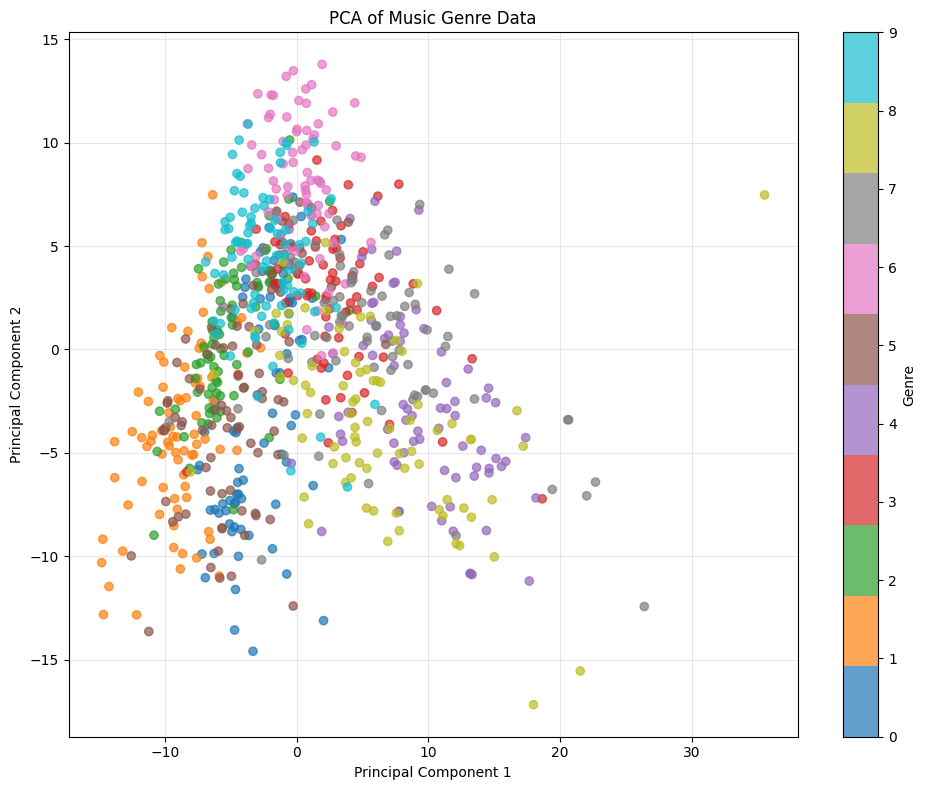

In [8]:

# Apply PCA for visualization
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_scaled)

# Visualize PCA results
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train_encoded, cmap='tab10', alpha=0.7)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Music Genre Data')
plt.colorbar(scatter, label='Genre')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [9]:

# Filter data with selected features for modeling
X_train_selected = selector.transform(X_train_scaled)
X_test_selected = selector.transform(X_test_scaled)

### 4. Model Training and Cross-Validation


In [10]:
print("\nTraining and evaluating multiple models...")

# Define models to evaluate
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'SVM': SVC(probability=True, random_state=42),
    'Neural Network': MLPClassifier(max_iter=1000, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42)
}

# Cross-validation evaluation
cv_results = {}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for name, model in models.items():
    start_time = time.time()
    scores = cross_val_score(model, X_train_selected, y_train_encoded, cv=cv, scoring='accuracy')
    end_time = time.time()
    cv_results[name] = {
        'mean_accuracy': scores.mean(),
        'std_accuracy': scores.std(),
        'time': end_time - start_time
    }
    print(f"{name}: Mean accuracy = {scores.mean():.4f}, Std = {scores.std():.4f}, Time = {end_time - start_time:.2f}s")


Training and evaluating multiple models...
Logistic Regression: Mean accuracy = 0.8137, Std = 0.0441, Time = 0.10s
K-Nearest Neighbors: Mean accuracy = 0.7225, Std = 0.0161, Time = 0.07s
Decision Tree: Mean accuracy = 0.6125, Std = 0.0301, Time = 0.09s
Random Forest: Mean accuracy = 0.7725, Std = 0.0135, Time = 0.87s
SVM: Mean accuracy = 0.8000, Std = 0.0333, Time = 0.26s
Neural Network: Mean accuracy = 0.8313, Std = 0.0244, Time = 1.96s
Gradient Boosting: Mean accuracy = 0.7825, Std = 0.0218, Time = 27.53s


In [11]:
# Identify top 3 models
top_models = sorted(cv_results.items(), key=lambda x: x[1]['mean_accuracy'], reverse=True)[:3]
print("\nTop 3 models:")
for name, results in top_models:
    print(f"{name}: Mean accuracy = {results['mean_accuracy']:.4f}")


Top 3 models:
Neural Network: Mean accuracy = 0.8313
Logistic Regression: Mean accuracy = 0.8137
SVM: Mean accuracy = 0.8000


### 5. Hyperparameter Tuning for Best Models

In [12]:
print("\nPerforming hyperparameter tuning for top models...")

# Define parameter grids for top models
param_grids = {
    'Random Forest': {
        'n_estimators': [100, 200, 300],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    'SVM': {
        'C': [0.1, 1, 10, 100],
        'gamma': ['scale', 'auto', 0.001, 0.01, 0.1],
        'kernel': ['rbf', 'poly', 'sigmoid']
    },
    'Gradient Boosting': {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7],
        'subsample': [0.8, 0.9, 1.0]
    },
    'Neural Network': {
        'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)],
        'activation': ['relu', 'tanh'],
        'alpha': [0.0001, 0.001, 0.01],
        'learning_rate': ['constant', 'adaptive']
    },
    'K-Nearest Neighbors': {
        'n_neighbors': [3, 5, 7, 9, 11],
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan', 'minkowski']
    },
    'Logistic Regression': {
        'C': [0.01, 0.1, 1, 10, 100],
        'solver': ['liblinear', 'saga'],
        'penalty': ['l1', 'l2']
    }
}


Performing hyperparameter tuning for top models...


In [13]:

# Tune hyperparameters for top models
best_models = {}
for name, _ in top_models:
    if name in param_grids:
        print(f"Tuning {name}...")
        model = models[name]
        param_grid = param_grids[name]
        
        grid_search = GridSearchCV(
            estimator=model,
            param_grid=param_grid,
            cv=3,
            scoring='accuracy',
            n_jobs=-1
        )
        
        grid_search.fit(X_train_selected, y_train_encoded)
        
        best_models[name] = grid_search.best_estimator_
        print(f"Best parameters for {name}: {grid_search.best_params_}")
        print(f"Best cross-validation accuracy: {grid_search.best_score_:.4f}")

Tuning Neural Network...
Best parameters for Neural Network: {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,), 'learning_rate': 'constant'}
Best cross-validation accuracy: 0.7775
Tuning Logistic Regression...


/Users/sid/Developer/UPF/SMC/Term 1/advanced-topics-in-smc/Assignments/Genre Classification/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/sid/Developer/UPF/SMC/Term 1/advanced-topics-in-smc/Assignments/Genre Classification/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/sid/Developer/UPF/SMC/Term 1/advanced-topics-in-smc/Assignments/Genre Classification/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/sid/Developer/UPF/SMC/Term 1/advanced-topics-in-smc/Assignments/Genre Classification/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which me

Best parameters for Logistic Regression: {'C': 1, 'penalty': 'l2', 'solver': 'saga'}
Best cross-validation accuracy: 0.7725
Tuning SVM...
Best parameters for SVM: {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}
Best cross-validation accuracy: 0.7899


### 6. Ensemble Learning (Voting Classifier)

In [14]:
print("\nBuilding ensemble model...")

# Create a voting classifier with the best models
estimators = [(name, model) for name, model in best_models.items()]
voting_clf = VotingClassifier(estimators=estimators, voting='soft')
voting_clf.fit(X_train_selected, y_train_encoded)


Building ensemble model...


VotingClassifier(estimators=[('Neural Network',
                              MLPClassifier(activation='tanh',
                                            hidden_layer_sizes=(50,),
                                            max_iter=1000, random_state=42)),
                             ('Logistic Regression',
                              LogisticRegression(C=1, max_iter=1000,
                                                 random_state=42,
                                                 solver='saga')),
                             ('SVM',
                              SVC(C=10, gamma=0.01, probability=True,
                                  random_state=42))],
                 voting='soft')

### 7. Final Evaluation on Test Set

In [15]:
print("\nEvaluating final models on test set...")

# Evaluate individual best models
for name, model in best_models.items():
    y_pred = model.predict(X_test_selected)
    accuracy = accuracy_score(y_test_encoded, y_pred)
    print(f"{name} test accuracy: {accuracy:.4f}")

# Evaluate ensemble model
y_pred_ensemble = voting_clf.predict(X_test_selected)
ensemble_accuracy = accuracy_score(y_test_encoded, y_pred_ensemble)
print(f"Ensemble model test accuracy: {ensemble_accuracy:.4f}")

# Find the best overall model
best_model_name = max(best_models.items(), key=lambda x: accuracy_score(y_test_encoded, x[1].predict(X_test_selected)))[0]
best_model = best_models[best_model_name]
y_pred_best = best_model.predict(X_test_selected)
best_accuracy = accuracy_score(y_test_encoded, y_pred_best)

print(f"\nBest overall model: {best_model_name}")
print(f"Best model test accuracy: {best_accuracy:.4f}")


Evaluating final models on test set...
Neural Network test accuracy: 1.0000
Logistic Regression test accuracy: 0.9067
SVM test accuracy: 0.9482
Ensemble model test accuracy: 0.9948

Best overall model: Neural Network
Best model test accuracy: 1.0000



Classification Report:
              precision    recall  f1-score   support

         blu       1.00      1.00      1.00        20
         cla       1.00      1.00      1.00        13
         cou       1.00      1.00      1.00        20
         dis       1.00      1.00      1.00        20
         hip       1.00      1.00      1.00        20
         jaz       1.00      1.00      1.00        20
         met       1.00      1.00      1.00        20
         pop       1.00      1.00      1.00        20
         reg       1.00      1.00      1.00        20
         roc       1.00      1.00      1.00        20

    accuracy                           1.00       193
   macro avg       1.00      1.00      1.00       193
weighted avg       1.00      1.00      1.00       193



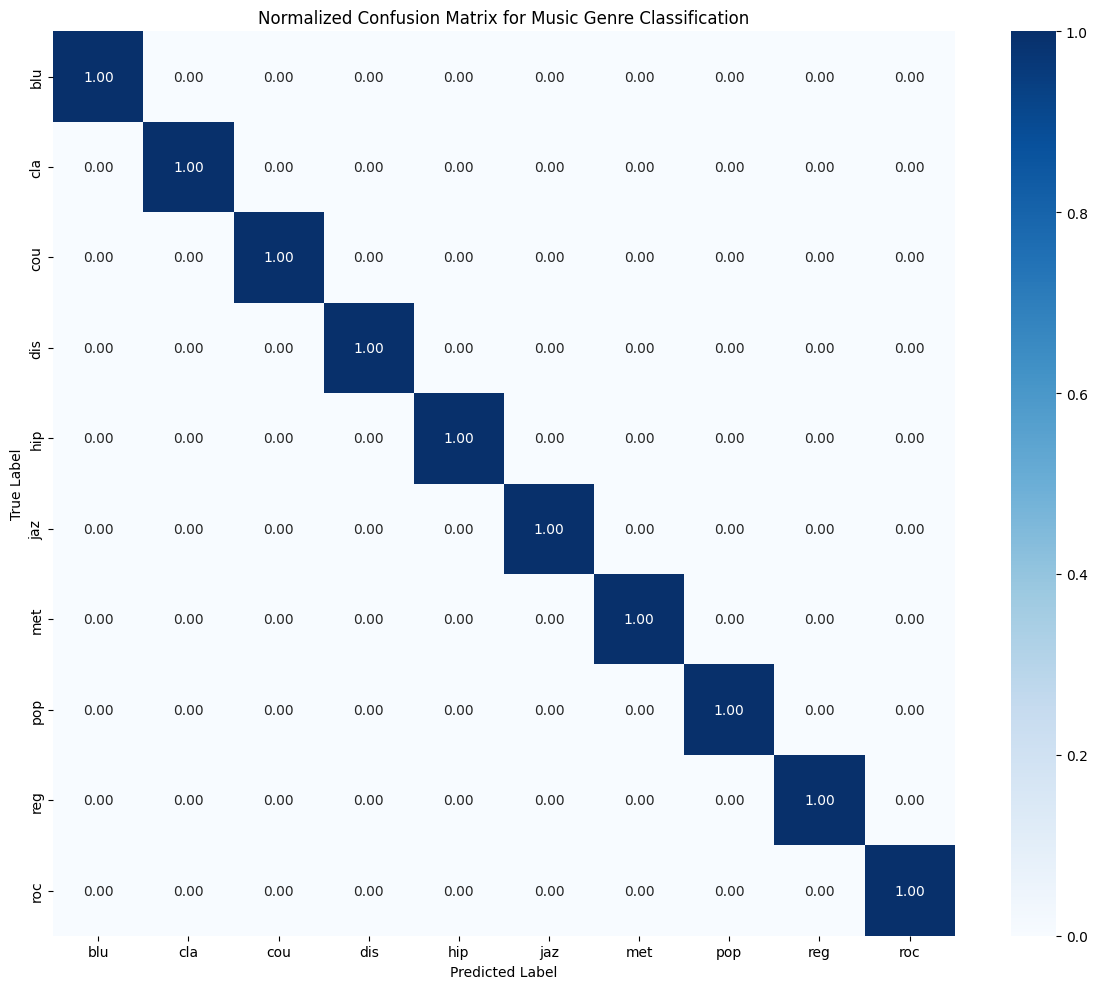

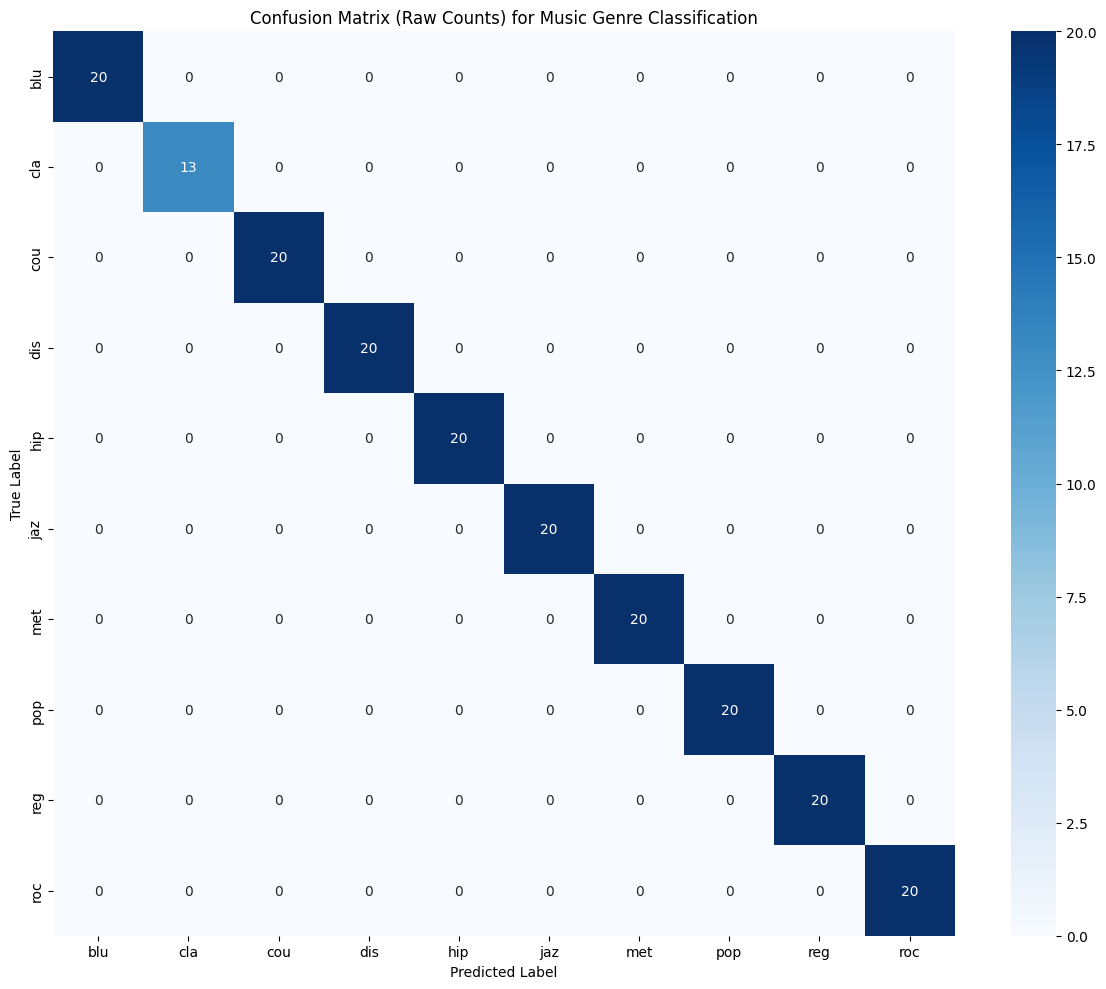

In [16]:
# Generate classification report
print("\nClassification Report:")
print(classification_report(y_test_encoded, y_pred_best, target_names=label_encoder.classes_))

# Plot normalized confusion matrix
plt.figure(figsize=(12, 10))
cm = confusion_matrix(y_test_encoded, y_pred_best)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # Normalize by row (true labels)

# Create heatmap with normalized values
sns.heatmap(
    cm_normalized, 
    annot=True, 
    fmt='.2f',  # Show as 2 decimal percentages
    cmap='Blues', 
    xticklabels=label_encoder.classes_, 
    yticklabels=label_encoder.classes_,
    vmin=0, 
    vmax=1  # Fix color scale from 0 to 1
)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Normalized Confusion Matrix for Music Genre Classification')
plt.tight_layout()
plt.show()

# Also show raw counts for reference
plt.figure(figsize=(12, 10))
sns.heatmap(
    cm, 
    annot=True, 
    fmt='d',  # Integer format for counts
    cmap='Blues', 
    xticklabels=label_encoder.classes_, 
    yticklabels=label_encoder.classes_
)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Raw Counts) for Music Genre Classification')
plt.tight_layout()
plt.show()

# Feature importance for the best model (if applicable)
if hasattr(best_model, 'feature_importances_'):
    feature_importance = pd.DataFrame({
        'Feature': selected_features,
        'Importance': best_model.feature_importances_
    }).sort_values(by='Importance', ascending=False)
    
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=feature_importance.head(15))
    plt.title('Top 15 Important Features')
    plt.tight_layout()
    plt.show()

# Music Genre Classification - Task 2
Using features_30_sec.csv and features_3_sec.csv datasets


In [17]:
import time
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.ensemble import (
    GradientBoostingClassifier,
    RandomForestClassifier,
    VotingClassifier,
)
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import (
    GridSearchCV,
    StratifiedKFold,
    cross_val_score,
    train_test_split,
)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

warnings.filterwarnings('ignore')

In [18]:
# Set random seed for reproducibility
np.random.seed(42)

### 1. Data Loading and Exploration

In [19]:
print("Loading CSV feature files...")

# Define data paths
data_folder = 'data'

features_30_sec = pd.read_csv(f'{data_folder}/features_30_sec.csv')
features_3_sec = pd.read_csv(f'{data_folder}/features_3_sec.csv')

print(f"30-second features shape: {features_30_sec.shape}")
print(f"3-second features shape: {features_3_sec.shape}")

# Display sample data
print("\nSample of 30-second features:")
print(features_30_sec.head())

print("\nFeature statistics (30-second):")
print(features_30_sec.describe().T)

print("\nGenre distribution (30-second):")
print(features_30_sec['label'].value_counts())

Loading CSV feature files...
30-second features shape: (1000, 60)
3-second features shape: (9990, 60)

Sample of 30-second features:
          filename  length  chroma_stft_mean  chroma_stft_var  rms_mean  \
0  blues.00000.wav  661794          0.350088         0.088757  0.130228   
1  blues.00001.wav  661794          0.340914         0.094980  0.095948   
2  blues.00002.wav  661794          0.363637         0.085275  0.175570   
3  blues.00003.wav  661794          0.404785         0.093999  0.141093   
4  blues.00004.wav  661794          0.308526         0.087841  0.091529   

    rms_var  spectral_centroid_mean  spectral_centroid_var  \
0  0.002827             1784.165850          129774.064525   
1  0.002373             1530.176679          375850.073649   
2  0.002746             1552.811865          156467.643368   
3  0.006346             1070.106615          184355.942417   
4  0.002303             1835.004266          343399.939274   

   spectral_bandwidth_mean  spectral_bandwi

In [21]:
# Check for missing values
print("\nMissing values in 30-second features:")
print(features_30_sec.isnull().sum().sum())
print("Missing values in 3-second features:")
print(features_3_sec.isnull().sum().sum())


Missing values in 30-second features:
0
Missing values in 3-second features:
0


### 2. Data Preprocessing Function

In [22]:
def preprocess_data(df, test_size=0.2):
    # Drop non-feature columns
    X = df.drop(['filename', 'label', 'length'], axis=1)
    y = df['label']
    
    # Encode target variable
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)
    
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y_encoded, test_size=test_size, random_state=42, stratify=y_encoded
    )
    
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    return X_train_scaled, X_test_scaled, y_train, y_test, label_encoder

### 3. Feature Selection Function

In [23]:
def select_features(X_train, y_train, X_test, feature_names, k=20):
    # Create selector and fit
    selector = SelectKBest(score_func=f_classif, k=k)
    selector.fit(X_train, y_train)
    
    # Get selected feature indices and scores
    selected_indices = selector.get_support(indices=True)
    scores = selector.scores_
    
    # Get names of selected features
    selected_features = [feature_names[i] for i in selected_indices]
    
    # Sort features by importance
    feature_scores = sorted(zip(selected_features, scores[selected_indices]), 
                         key=lambda x: x[1], reverse=True)
    
    # Apply transformation
    X_train_selected = selector.transform(X_train)
    X_test_selected = selector.transform(X_test)
    
    return X_train_selected, X_test_selected, feature_scores, selector

### 4. Model Training and Evaluation Function

In [24]:
def train_and_evaluate_models(X_train, y_train, X_test, y_test, label_encoder):
    # Define models to evaluate
    models = {
        'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
        'K-Nearest Neighbors': KNeighborsClassifier(),
        'Decision Tree': DecisionTreeClassifier(random_state=42),
        'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
        'SVM': SVC(probability=True, random_state=42),
        'Neural Network': MLPClassifier(max_iter=1000, random_state=42),
        'Gradient Boosting': GradientBoostingClassifier(random_state=42)
    }
    
    # Cross-validation evaluation
    cv_results = {}
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    for name, model in models.items():
        start_time = time.time()
        scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='accuracy')
        end_time = time.time()
        cv_results[name] = {
            'mean_accuracy': scores.mean(),
            'std_accuracy': scores.std(),
            'time': end_time - start_time
        }
        print(f"{name}: Mean accuracy = {scores.mean():.4f}, Std = {scores.std():.4f}, Time = {end_time - start_time:.2f}s")
    
    # Identify top 3 models
    top_models = sorted(cv_results.items(), key=lambda x: x[1]['mean_accuracy'], reverse=True)[:3]
    print("\nTop 3 models:")
    for name, results in top_models:
        print(f"{name}: Mean accuracy = {results['mean_accuracy']:.4f}")
    
    # Define parameter grids for hyperparameter tuning
    param_grids = {
        'Random Forest': {
            'n_estimators': [100, 200, 300],
            'max_depth': [None, 10, 20, 30],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4]
        },
        'SVM': {
            'C': [0.1, 1, 10, 100],
            'gamma': ['scale', 'auto', 0.001, 0.01, 0.1],
            'kernel': ['rbf', 'poly', 'sigmoid']
        },
        'Gradient Boosting': {
            'n_estimators': [100, 200, 300],
            'learning_rate': [0.01, 0.1, 0.2],
            'max_depth': [3, 5, 7],
            'subsample': [0.8, 0.9, 1.0]
        }
    }
    
    # Tune hyperparameters for top models
    best_models = {}
    for name, _ in top_models:
        if name in param_grids:
            print(f"Tuning {name}...")
            model = models[name]
            param_grid = param_grids[name]
            
            grid_search = GridSearchCV(
                estimator=model,
                param_grid=param_grid,
                cv=3,
                scoring='accuracy',
                n_jobs=-1
            )
            
            grid_search.fit(X_train, y_train)
            
            best_models[name] = grid_search.best_estimator_
            print(f"Best parameters for {name}: {grid_search.best_params_}")
            print(f"Best cross-validation accuracy: {grid_search.best_score_:.4f}")
    
    # Final evaluation on test set
    for name, model in best_models.items():
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        print(f"{name} test accuracy: {accuracy:.4f}")
    
    # Find the best overall model
    best_model_name = max(best_models.items(), key=lambda x: accuracy_score(y_test, x[1].predict(X_test)))[0]
    best_model = best_models[best_model_name]
    y_pred_best = best_model.predict(X_test)
    best_accuracy = accuracy_score(y_test, y_pred_best)
    
    print(f"\nBest overall model: {best_model_name}")
    print(f"Best model test accuracy: {best_accuracy:.4f}")
    
    # Classification report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred_best, target_names=label_encoder.classes_))
    
    # Plot normalized confusion matrix
    plt.figure(figsize=(12, 10))
    cm = confusion_matrix(y_test, y_pred_best)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    sns.heatmap(
        cm_normalized, 
        annot=True, 
        fmt='.2f', 
        cmap='Blues', 
        xticklabels=label_encoder.classes_, 
        yticklabels=label_encoder.classes_,
        vmin=0, 
        vmax=1
    )
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Normalized Confusion Matrix')
    plt.tight_layout()
    plt.show()
    
    return best_model, best_accuracy, best_model_name

### 5. Process 30-second features

In [25]:
print("\n\n========== 30-Second Features Analysis ==========")

# Preprocess data
X_train_30sec, X_test_30sec, y_train_30sec, y_test_30sec, label_encoder_30sec = preprocess_data(features_30_sec)

# Feature selection
feature_names_30sec = features_30_sec.drop(['filename', 'label', 'length'], axis=1).columns
k_best_30sec = min(20, len(feature_names_30sec))
X_train_30sec_selected, X_test_30sec_selected, feature_scores_30sec, selector_30sec = select_features(
    X_train_30sec, y_train_30sec, X_test_30sec, feature_names_30sec, k=k_best_30sec
)

print(f"\nTop {k_best_30sec} selected features by importance (30-second features):")
for i, (feature, score) in enumerate(feature_scores_30sec):
    print(f"{i+1}. {feature}: {score:.4f}")



========== 30-Second Features Analysis ==========

Top 20 selected features by importance (30-second features):
1. chroma_stft_mean: 141.6912
2. mfcc1_mean: 102.3540
3. spectral_bandwidth_mean: 91.3928
4. rolloff_mean: 86.2187
5. spectral_centroid_mean: 77.1289
6. spectral_centroid_var: 69.7194
7. mfcc4_mean: 69.0991
8. perceptr_var: 67.9129
9. mfcc2_mean: 64.2944
10. rms_mean: 57.3128
11. chroma_stft_var: 56.6697
12. rms_var: 53.6807
13. mfcc8_mean: 52.3639
14. mfcc6_mean: 50.7515
15. zero_crossing_rate_mean: 49.9063
16. mfcc17_mean: 48.9210
17. mfcc4_var: 48.5785
18. mfcc6_var: 48.2407
19. zero_crossing_rate_var: 47.8612
20. mfcc7_var: 44.6403


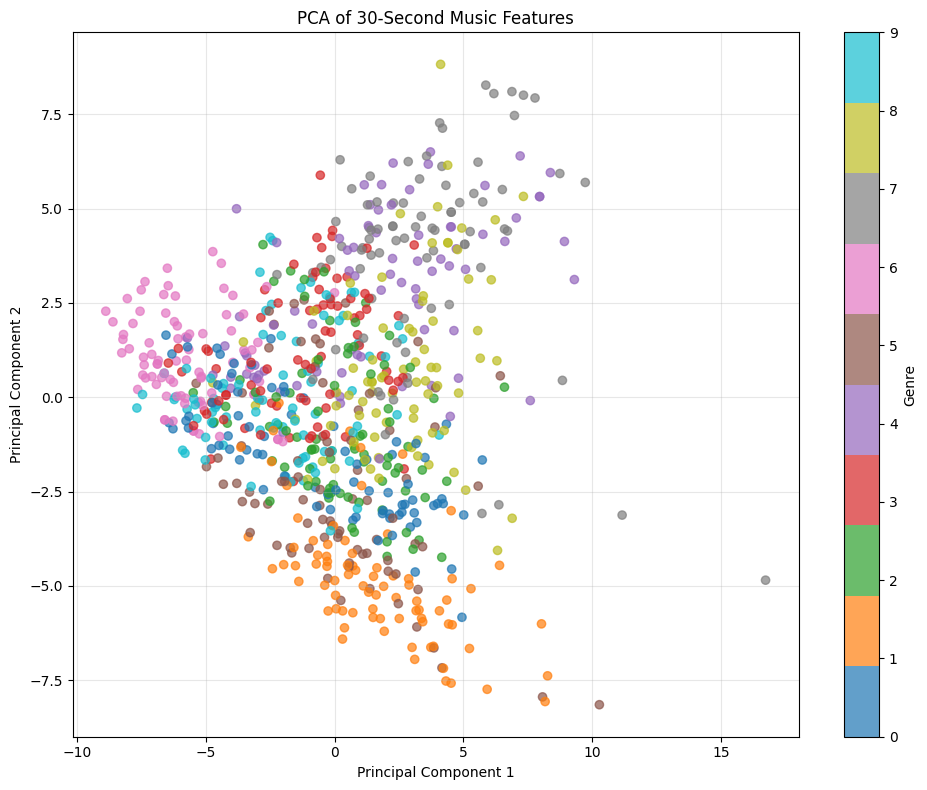

In [26]:
# Visualize data with PCA
pca_30sec = PCA(n_components=2)
X_train_30sec_pca = pca_30sec.fit_transform(X_train_30sec)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_train_30sec_pca[:, 0], X_train_30sec_pca[:, 1], c=y_train_30sec, cmap='tab10', alpha=0.7)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of 30-Second Music Features')
plt.colorbar(scatter, label='Genre')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

Logistic Regression: Mean accuracy = 0.6400, Std = 0.0427, Time = 0.07s
K-Nearest Neighbors: Mean accuracy = 0.5875, Std = 0.0259, Time = 0.01s
Decision Tree: Mean accuracy = 0.4675, Std = 0.0478, Time = 0.04s
Random Forest: Mean accuracy = 0.6500, Std = 0.0163, Time = 0.68s
SVM: Mean accuracy = 0.6550, Std = 0.0302, Time = 0.22s
Neural Network: Mean accuracy = 0.6625, Std = 0.0345, Time = 3.65s
Gradient Boosting: Mean accuracy = 0.6475, Std = 0.0255, Time = 11.83s

Top 3 models:
Neural Network: Mean accuracy = 0.6625
SVM: Mean accuracy = 0.6550
Random Forest: Mean accuracy = 0.6500
Tuning SVM...
Best parameters for SVM: {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}
Best cross-validation accuracy: 0.6725
Tuning Random Forest...
Best parameters for Random Forest: {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
Best cross-validation accuracy: 0.6462
SVM test accuracy: 0.6650
Random Forest test accuracy: 0.6650

Best overall model: SVM
Best model test acc

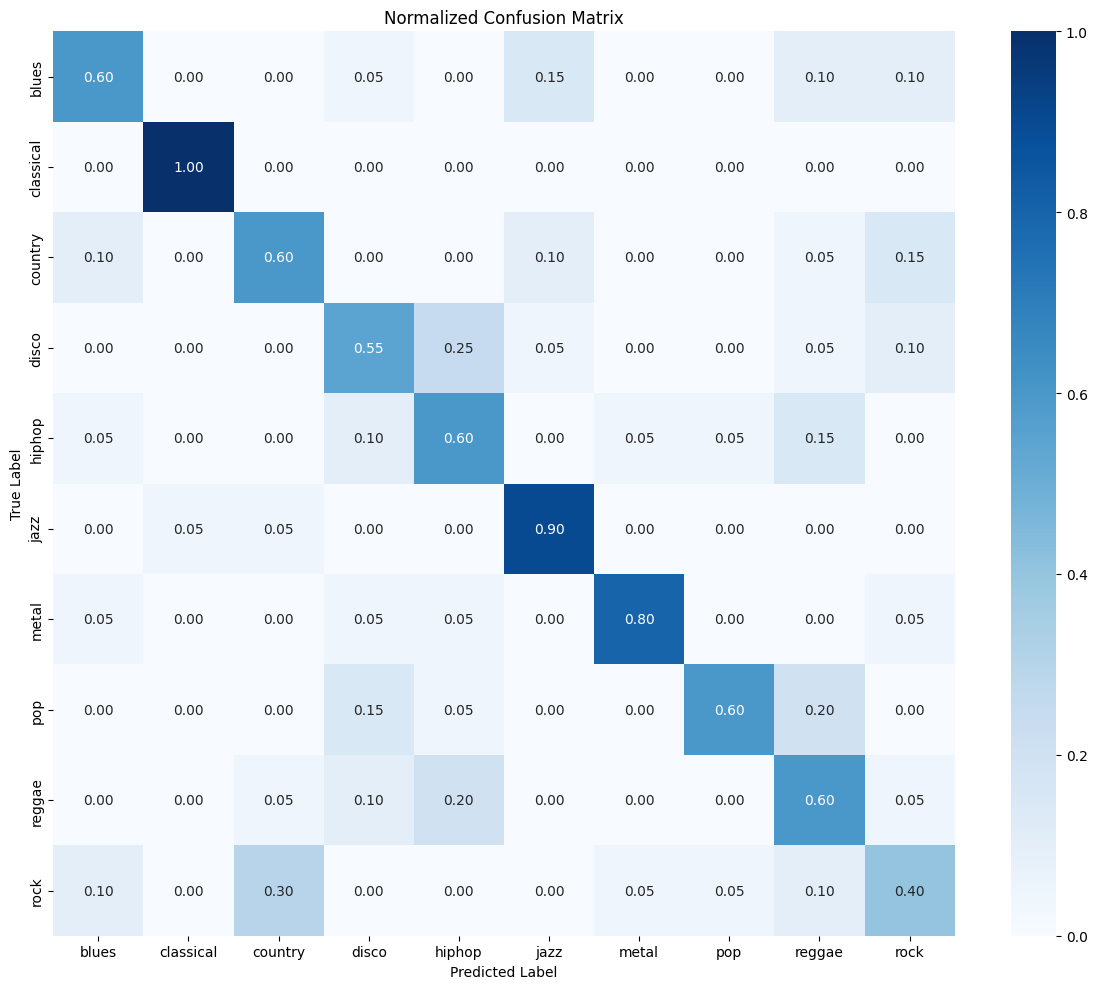

In [27]:

# Train models
best_model_30sec, best_accuracy_30sec, best_model_name_30sec = train_and_evaluate_models(
    X_train_30sec_selected, y_train_30sec, X_test_30sec_selected, y_test_30sec, label_encoder_30sec
)

# Feature importance for the best model (if applicable)
if hasattr(best_model_30sec, 'feature_importances_'):
    selected_feature_names = [feature_names_30sec[i] for i in selector_30sec.get_support(indices=True)]
    feature_importance = pd.DataFrame({
        'Feature': selected_feature_names,
        'Importance': best_model_30sec.feature_importances_
    }).sort_values(by='Importance', ascending=False)
    
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=feature_importance.head(15))
    plt.title('Top 15 Important Features - 30-Second Analysis')
    plt.tight_layout()
    plt.show()

### 6. Process 3-second features

In [28]:

print("\n\n========== 3-Second Features Analysis ==========")
# Preprocess data
X_train_3sec, X_test_3sec, y_train_3sec, y_test_3sec, label_encoder_3sec = preprocess_data(features_3_sec)

# Feature selection
feature_names_3sec = features_3_sec.drop(['filename', 'label', 'length'], axis=1).columns
k_best_3sec = min(20, len(feature_names_3sec))
X_train_3sec_selected, X_test_3sec_selected, feature_scores_3sec, selector_3sec = select_features(
    X_train_3sec, y_train_3sec, X_test_3sec, feature_names_3sec, k=k_best_3sec
)

print(f"\nTop {k_best_3sec} selected features by importance (3-second features):")
for i, (feature, score) in enumerate(feature_scores_3sec):
    print(f"{i+1}. {feature}: {score:.4f}")



========== 3-Second Features Analysis ==========

Top 20 selected features by importance (3-second features):
1. chroma_stft_mean: 887.8737
2. spectral_bandwidth_mean: 842.0843
3. mfcc1_mean: 832.5185
4. rolloff_mean: 773.4334
5. spectral_centroid_mean: 662.6649
6. mfcc2_mean: 608.1100
7. perceptr_var: 582.2388
8. mfcc4_mean: 524.8679
9. rms_mean: 506.7357
10. rms_var: 467.7784
11. spectral_centroid_var: 467.3728
12. mfcc8_mean: 432.9335
13. mfcc6_mean: 403.4727
14. zero_crossing_rate_mean: 353.7679
15. mfcc9_mean: 350.3705
16. rolloff_var: 347.8183
17. mfcc6_var: 335.0206
18. mfcc4_var: 323.5015
19. mfcc5_var: 313.4589
20. mfcc7_mean: 301.4984


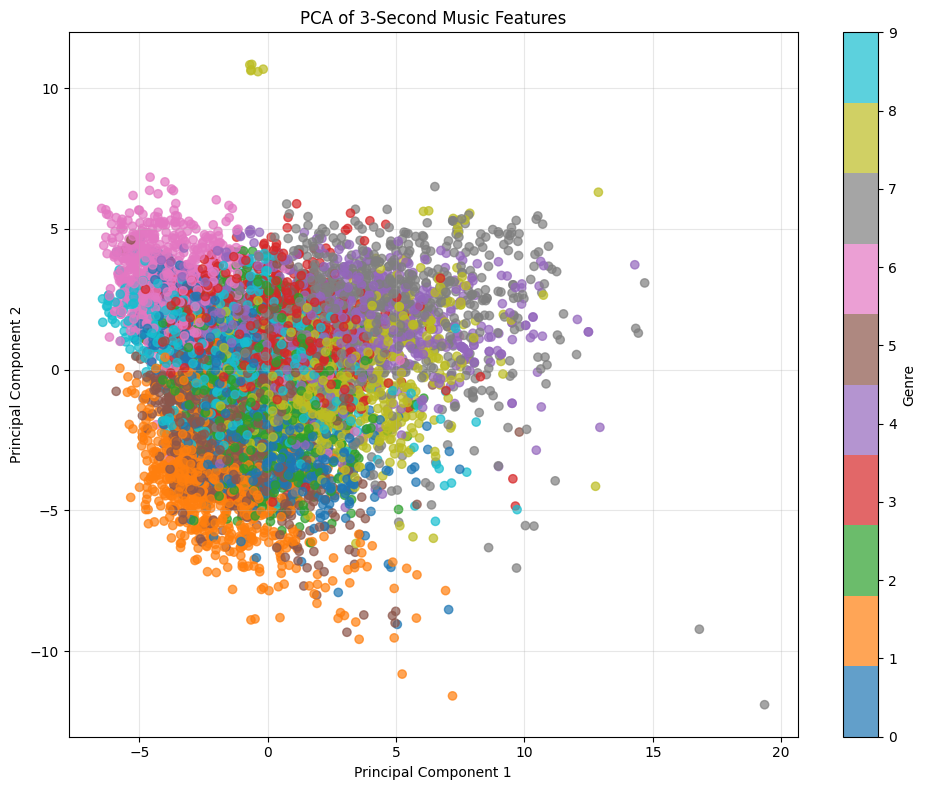

In [29]:
# Visualize data with PCA
pca_3sec = PCA(n_components=2)
X_train_3sec_pca = pca_3sec.fit_transform(X_train_3sec)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_train_3sec_pca[:, 0], X_train_3sec_pca[:, 1], c=y_train_3sec, cmap='tab10', alpha=0.7)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of 3-Second Music Features')
plt.colorbar(scatter, label='Genre')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

Logistic Regression: Mean accuracy = 0.6331, Std = 0.0158, Time = 0.35s
K-Nearest Neighbors: Mean accuracy = 0.8141, Std = 0.0063, Time = 0.04s
Decision Tree: Mean accuracy = 0.6137, Std = 0.0130, Time = 0.57s
Random Forest: Mean accuracy = 0.8111, Std = 0.0096, Time = 7.18s
SVM: Mean accuracy = 0.7561, Std = 0.0106, Time = 10.29s
Neural Network: Mean accuracy = 0.7913, Std = 0.0051, Time = 32.58s
Gradient Boosting: Mean accuracy = 0.7297, Std = 0.0150, Time = 137.43s

Top 3 models:
K-Nearest Neighbors: Mean accuracy = 0.8141
Random Forest: Mean accuracy = 0.8111
Neural Network: Mean accuracy = 0.7913
Tuning Random Forest...
Best parameters for Random Forest: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Best cross-validation accuracy: 0.8009
Random Forest test accuracy: 0.8153

Best overall model: Random Forest
Best model test accuracy: 0.8153

Classification Report:
              precision    recall  f1-score   support

       blues       0.80 

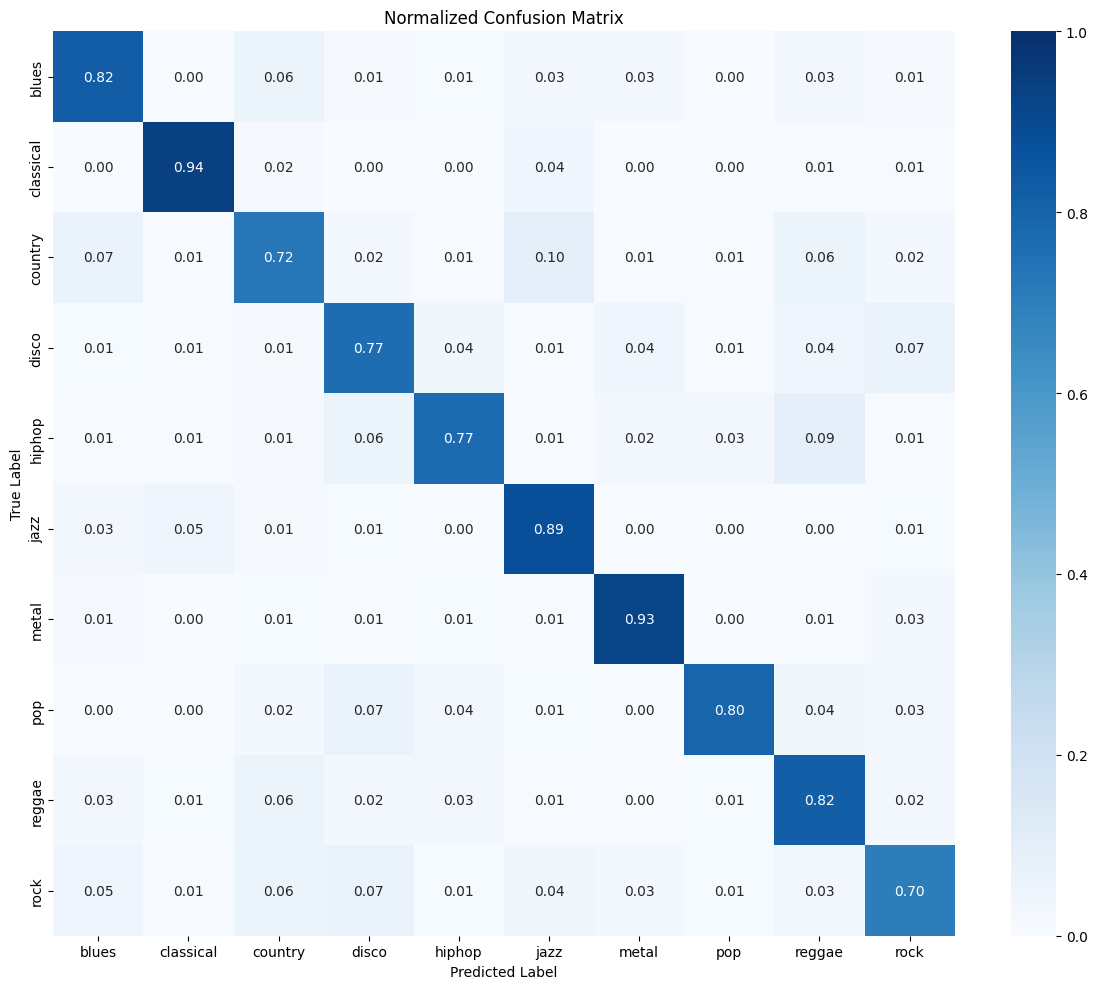

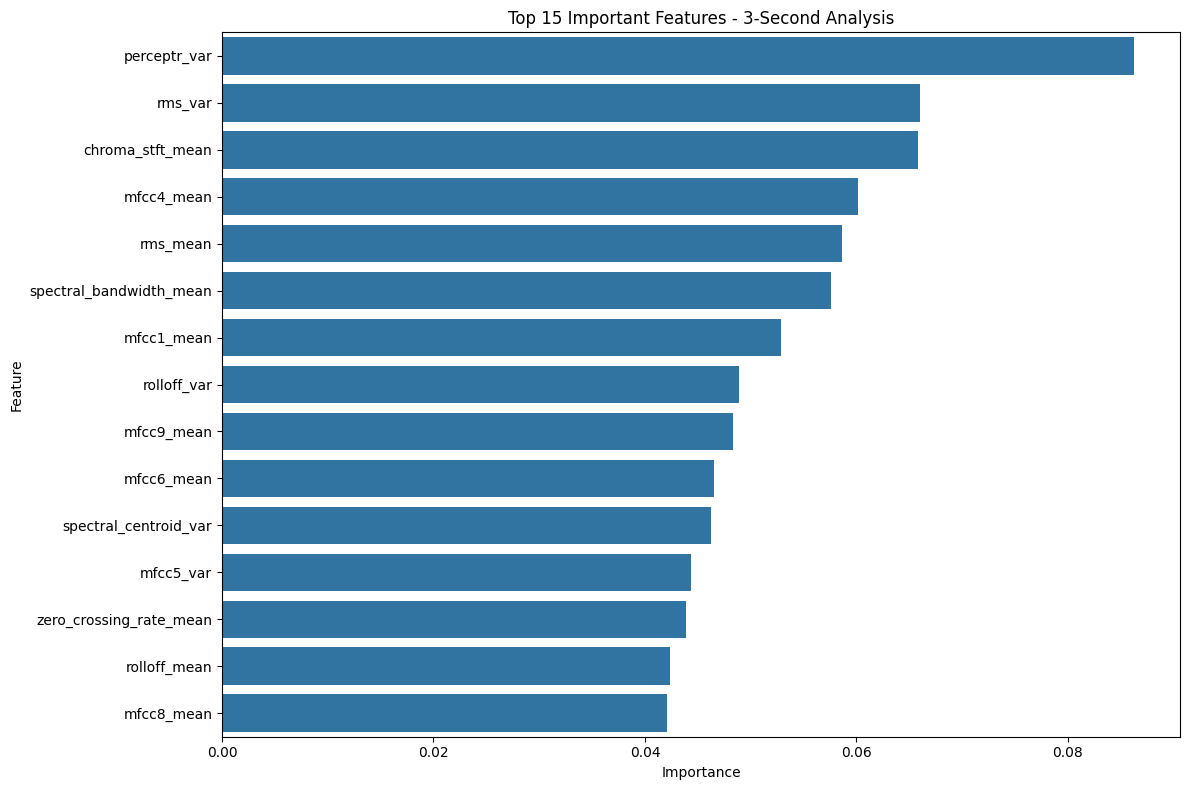

In [30]:

# Train models
best_model_3sec, best_accuracy_3sec, best_model_name_3sec = train_and_evaluate_models(
    X_train_3sec_selected, y_train_3sec, X_test_3sec_selected, y_test_3sec, label_encoder_3sec
)

# Feature importance for the best model (if applicable)
if hasattr(best_model_3sec, 'feature_importances_'):
    selected_feature_names = [feature_names_3sec[i] for i in selector_3sec.get_support(indices=True)]
    feature_importance = pd.DataFrame({
        'Feature': selected_feature_names,
        'Importance': best_model_3sec.feature_importances_
    }).sort_values(by='Importance', ascending=False)
    
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=feature_importance.head(15))
    plt.title('Top 15 Important Features - 3-Second Analysis')
    plt.tight_layout()
    plt.show()

### 7. Compare Results

In [31]:
print("\n\n========== Comparison of Results ==========")
print(f"30-second features - Best model: {best_model_name_30sec}, Accuracy: {best_accuracy_30sec:.4f}")
print(f"3-second features - Best model: {best_model_name_3sec}, Accuracy: {best_accuracy_3sec:.4f}")

# Final comparison
print("\n\n========== Final Comparison ==========")
print(f"30-second features - Best model: {best_model_name_30sec}, Accuracy: {best_accuracy_30sec:.4f}")
print(f"3-second features - Best model: {best_model_name_3sec}, Accuracy: {best_accuracy_3sec:.4f}")

# Identify the better approach
best_approach = "30-second features" if best_accuracy_30sec > best_accuracy_3sec else "3-second features"
best_accuracy = max(best_accuracy_30sec, best_accuracy_3sec)
print(f"\nBetter approach: {best_approach} with {best_accuracy:.4f} accuracy")



========== Comparison of Results ==========
30-second features - Best model: SVM, Accuracy: 0.6650
3-second features - Best model: Random Forest, Accuracy: 0.8153


========== Final Comparison ==========
30-second features - Best model: SVM, Accuracy: 0.6650
3-second features - Best model: Random Forest, Accuracy: 0.8153

Better approach: 3-second features with 0.8153 accuracy


# Music Genre Classification - Task 3
Using Spectrograms with Convolutional Neural Networks

In [ ]:
# Using Custom CNN and Audio Spectrogram Transformer (AST)

import os
import warnings

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm

warnings.filterwarnings('ignore')

In [ ]:
# Set random seed for reproducibility
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.backends.cudnn.deterministic = True

In [ ]:
# Check for GPU availability (including Apple Silicon)
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print(f"Using MPS (Metal) device on Apple Silicon")
elif torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"Using CUDA device: {torch.cuda.get_device_name(0)}")
else:
    device = torch.device("cpu")
    print("Using CPU (GPU not available)")

Using MPS (Metal) device on Apple Silicon


In [ ]:
# Print PyTorch version for reference
print(f"PyTorch version: {torch.__version__}")

PyTorch version: 2.6.0


### 1. Data Loading and Preprocessing

In [ ]:
print("Loading spectrogram images...")

# Define path to spectrograms
spectrogram_dir = 'data/images_original'
genres = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']

# Function to load and preprocess images
def load_spectrograms(base_dir, target_size=(224, 224)):
    images = []
    labels = []
    filenames = []
    
    for genre_idx, genre in enumerate(genres):
        genre_dir = os.path.join(base_dir, genre)
        if not os.path.exists(genre_dir):
            print(f"Warning: {genre_dir} does not exist. Skipping.")
            continue
            
        for img_file in os.listdir(genre_dir):
            if not img_file.endswith('.png'):
                continue
                
            # Load image
            img_path = os.path.join(genre_dir, img_file)
            try:
                # Read image
                img = cv2.imread(img_path)
                # Convert BGR to RGB
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                # Resize
                img = cv2.resize(img, target_size)
                # Normalize (PyTorch expects CHW format)
                img = img.transpose(2, 0, 1) / 255.0
                
                # Save data
                images.append(img)
                labels.append(genre_idx)
                filenames.append(img_file)
            except Exception as e:
                print(f"Error loading {img_path}: {e}")
    
    return np.array(images, dtype=np.float32), np.array(labels), filenames

# Load spectrograms
X, y, filenames = load_spectrograms(spectrogram_dir)

# Check data
print(f"Loaded {len(X)} spectrogram images")
print(f"Image shape: {X[0].shape}")
print(f"Number of classes: {len(np.unique(y))}")
print(f"Class distribution:")
for i, genre in enumerate(genres):
    count = np.sum(y == i)
    print(f"  {genre}: {count} images")

Loading spectrogram images...
Loaded 999 spectrogram images
Image shape: (3, 224, 224)
Number of classes: 10
Class distribution:
  blues: 100 images
  classical: 100 images
  country: 100 images
  disco: 100 images
  hiphop: 100 images
  jazz: 99 images
  metal: 100 images
  pop: 100 images
  reggae: 100 images
  rock: 100 images


In [ ]:
# Split data into training and testing sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Testing set: {X_test.shape[0]} samples")

Training set: 799 samples
Testing set: 200 samples


### 2. Create PyTorch Dataset and DataLoader

In [ ]:

class MusicSpectrogramDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        
        # Apply transformations if specified
        if self.transform:
            # Convert to PyTorch tensor first (already in CHW format)
            image_tensor = torch.tensor(image)
            image_tensor = self.transform(image_tensor)
            return image_tensor, label
        
        return torch.tensor(image), label

# Define data augmentation for training
train_transform = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
])

# Create datasets
train_dataset = MusicSpectrogramDataset(X_train, y_train, transform=train_transform)
test_dataset = MusicSpectrogramDataset(X_test, y_test)

# Create dataloaders (num_workers=0 for Jupyter notebook compatibility)
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

### 3. Model Definitions

#### Custom CNN Model

In [ ]:
# 3.1 Custom CNN Model
class CustomCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(CustomCNN, self).__init__()
        
        # First convolutional block
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.25)
        )
        
        # Second convolutional block
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.25)
        )
        
        # Third convolutional block
        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.25)
        )
        
        # Fourth convolutional block
        self.conv4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.25)
        )
        
        # Calculate size after convolutions (assuming 224x224 input)
        # After 4 max-pooling layers with stride 2: 224/(2^4) = 14
        self.fc_input_size = 256 * 14 * 14
        
        # Fully connected layers
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(self.fc_input_size, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.fc(x)
        return x

#### Pretrained Model (Audio Spectrogram Transformer)

In [ ]:
# 3.2 Audio Spectrogram Transformer (AST) Model
class PatchEmbed(nn.Module):
    """
    2D Image to Patch Embedding
    """
    def __init__(self, img_size=224, patch_size=16, in_chans=3, embed_dim=768):
        super().__init__()
        self.img_size = (img_size, img_size)
        self.patch_size = (patch_size, patch_size)
        self.grid_size = (self.img_size[0] // self.patch_size[0], 
                         self.img_size[1] // self.patch_size[1])
        self.num_patches = self.grid_size[0] * self.grid_size[1]
        
        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)
        
    def forward(self, x):
        B, C, H, W = x.shape
        assert H == self.img_size[0] and W == self.img_size[1], \
            f"Input image size ({H}*{W}) doesn't match model ({self.img_size[0]}*{self.img_size[1]})."
        
        # Flatten: [B, C, H, W] -> [B, C, HW]
        x = self.proj(x).flatten(2)
        # Transpose: [B, C, HW] -> [B, HW, C]
        x = x.transpose(1, 2)
        return x

class AST(nn.Module):
    """
    Audio Spectrogram Transformer
    """
    def __init__(self, img_size=224, patch_size=16, in_chans=3, num_classes=10, 
                 embed_dim=768, depth=12, num_heads=12, mlp_ratio=4., 
                 qkv_bias=True, drop_rate=0.):
        super().__init__()
        
        # Patch Embedding
        self.patch_embed = PatchEmbed(
            img_size=img_size, patch_size=patch_size, in_chans=in_chans, embed_dim=embed_dim)
        num_patches = self.patch_embed.num_patches
        
        # Class token
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        # Position embedding
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, embed_dim))
        self.pos_drop = nn.Dropout(p=drop_rate)
        
        # Transformer Encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim, 
            nhead=num_heads,
            dim_feedforward=int(embed_dim * mlp_ratio),
            dropout=drop_rate,
            activation='gelu',
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=depth)
        
        # MLP Head
        self.norm = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, num_classes)
        
        # Initialize weights
        self._init_weights()
        
    def _init_weights(self):
        # Use normal initialization
        nn.init.normal_(self.pos_embed, std=.02)
        nn.init.normal_(self.cls_token, std=.02)
        self.apply(self._init_weights_layers)
        
    def _init_weights_layers(self, m):
        if isinstance(m, nn.Linear):
            nn.init.normal_(m.weight, std=.02)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)
            
    def forward(self, x):
        # Patch embedding
        x = self.patch_embed(x)
        
        # Add class token
        cls_token = self.cls_token.expand(x.shape[0], -1, -1)
        x = torch.cat((cls_token, x), dim=1)
        
        # Add position embedding
        x = x + self.pos_embed
        x = self.pos_drop(x)
        
        # Apply Transformer encoder
        x = self.transformer_encoder(x)
        
        # Use the class token for classification
        x = self.norm(x[:, 0])
        x = self.head(x)
        
        return x

### 4. Training and Evaluation Functions

In [ ]:
def train_model(model, train_loader, criterion, optimizer, device, scheduler=None):
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    
    for inputs, targets in tqdm(train_loader, desc="Training"):
        inputs, targets = inputs.to(device), targets.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        
        # Backward and optimize
        loss.backward()
        optimizer.step()
        
        # Statistics
        train_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
    
    if scheduler:
        scheduler.step()
        
    epoch_loss = train_loss / total
    epoch_acc = correct / total
    
    return epoch_loss, epoch_acc

def evaluate_model(model, test_loader, criterion, device):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for inputs, targets in tqdm(test_loader, desc="Evaluating"):
            inputs, targets = inputs.to(device), targets.to(device)
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            # Statistics
            test_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            
            # Store predictions and targets for later analysis
            all_preds.extend(predicted.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())
    
    epoch_loss = test_loss / total
    epoch_acc = correct / total
    
    return epoch_loss, epoch_acc, np.array(all_preds), np.array(all_targets)

### 5. Training Loop

In [ ]:
def train_and_evaluate(model_name, model, train_loader, test_loader, num_epochs=50, learning_rate=0.001):
    print(f"\nTraining {model_name}...")
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)
    
    # Training loop
    history = {
        'train_loss': [], 'train_acc': [],
        'val_loss': [], 'val_acc': []
    }

    best_val_acc = 0.0
    patience_counter = 0
    patience = 10  # Early stopping patience

    for epoch in range(num_epochs):
        # Train
        train_loss, train_acc = train_model(
            model, train_loader, criterion, optimizer, device, scheduler
        )
        
        # Evaluate
        val_loss, val_acc, _, _ = evaluate_model(
            model, test_loader, criterion, device
        )
        
        # Store history
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
        # Print progress
        print(f'Epoch {epoch+1}/{num_epochs}: train_loss={train_loss:.4f}, train_acc={train_acc:.4f}, val_loss={val_loss:.4f}, val_acc={val_acc:.4f}')
        
        # Early stopping
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            # Save the best model
            torch.save(model.state_dict(), f'best_{model_name}_model.pth')
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f'Early stopping at epoch {epoch+1}')
                break
    
    # Load best model for evaluation
    model.load_state_dict(torch.load(f'best_{model_name}_model.pth'))
    _, accuracy, predictions, targets = evaluate_model(
        model, test_loader, criterion, device
    )
    print(f"{model_name} Test Accuracy: {accuracy:.4f}")
    
    return model, history, accuracy, predictions, targets

### 6. Initialize and Train Models

In [ ]:
print("\nInitializing models...")

# Initialize Custom CNN model
custom_cnn = CustomCNN(num_classes=len(genres)).to(device)

# Initialize AST model with smaller dimensions for faster training
ast_model = AST(
    img_size=224,
    patch_size=16,
    in_chans=3,
    num_classes=len(genres),
    embed_dim=512,  # Smaller than original for faster training
    depth=8,        # Reduced depth
    num_heads=8,    # Reduced heads
    mlp_ratio=4.0,
    qkv_bias=True,
    drop_rate=0.1
).to(device)

# Train and evaluate each model
custom_cnn, cnn_history, cnn_accuracy, cnn_preds, cnn_targets = train_and_evaluate(
    'custom_cnn', custom_cnn, train_loader, test_loader, num_epochs=100, learning_rate=1e-3
)

ast_model, ast_history, ast_accuracy, ast_preds, ast_targets = train_and_evaluate(
    'ast', ast_model, train_loader, test_loader, num_epochs=100, learning_rate=1e-4
)


Initializing models...

Training custom_cnn...


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 12.17it/s]


Epoch 1/100: train_loss=2.1966, train_acc=0.2015, val_loss=3.0786, val_acc=0.1250


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 16.95it/s]


Epoch 2/100: train_loss=1.8331, train_acc=0.3467, val_loss=2.4332, val_acc=0.2600


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 17.14it/s]


Epoch 3/100: train_loss=1.5960, train_acc=0.4230, val_loss=1.4801, val_acc=0.5250


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 14.74it/s]


Epoch 4/100: train_loss=1.4692, train_acc=0.4981, val_loss=1.5910, val_acc=0.4350


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 15.82it/s]


Epoch 5/100: train_loss=1.3284, train_acc=0.5319, val_loss=1.8985, val_acc=0.3750


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 15.75it/s]


Epoch 6/100: train_loss=1.3126, train_acc=0.5294, val_loss=1.6335, val_acc=0.4650


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 15.59it/s]


Epoch 7/100: train_loss=1.2225, train_acc=0.5594, val_loss=1.8977, val_acc=0.3850


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 15.75it/s]


Epoch 8/100: train_loss=1.1739, train_acc=0.5832, val_loss=1.3818, val_acc=0.5250


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 15.52it/s]


Epoch 9/100: train_loss=1.1227, train_acc=0.6083, val_loss=1.2951, val_acc=0.5600


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 15.86it/s]


Epoch 10/100: train_loss=1.0042, train_acc=0.6621, val_loss=1.2107, val_acc=0.5900


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 15.89it/s]


Epoch 11/100: train_loss=0.9922, train_acc=0.6658, val_loss=1.3524, val_acc=0.5700


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 15.80it/s]


Epoch 12/100: train_loss=0.9370, train_acc=0.6758, val_loss=1.3661, val_acc=0.4600


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 15.88it/s]


Epoch 13/100: train_loss=0.9460, train_acc=0.6746, val_loss=1.2441, val_acc=0.5950


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 15.63it/s]


Epoch 14/100: train_loss=0.9298, train_acc=0.6834, val_loss=1.3168, val_acc=0.5750


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 15.61it/s]


Epoch 15/100: train_loss=0.8633, train_acc=0.6984, val_loss=1.0151, val_acc=0.6450


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 15.56it/s]


Epoch 16/100: train_loss=0.8738, train_acc=0.7096, val_loss=1.7224, val_acc=0.4750


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 16.42it/s]


Epoch 17/100: train_loss=0.8360, train_acc=0.7034, val_loss=1.2006, val_acc=0.5900


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 17.16it/s]


Epoch 18/100: train_loss=0.7912, train_acc=0.7359, val_loss=1.2267, val_acc=0.5900


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 17.21it/s]


Epoch 19/100: train_loss=0.7069, train_acc=0.7622, val_loss=1.0807, val_acc=0.6600


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 17.22it/s]


Epoch 20/100: train_loss=0.6423, train_acc=0.8035, val_loss=1.3537, val_acc=0.5350


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 17.25it/s]


Epoch 21/100: train_loss=0.6661, train_acc=0.7647, val_loss=1.0201, val_acc=0.6400


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 17.10it/s]


Epoch 22/100: train_loss=0.5884, train_acc=0.8060, val_loss=1.1723, val_acc=0.6600


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 17.12it/s]


Epoch 23/100: train_loss=0.5987, train_acc=0.7810, val_loss=1.0588, val_acc=0.6550


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 17.11it/s]


Epoch 24/100: train_loss=0.5590, train_acc=0.8160, val_loss=1.4300, val_acc=0.5850


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 17.10it/s]


Epoch 25/100: train_loss=0.6172, train_acc=0.7910, val_loss=1.3653, val_acc=0.5900


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 17.37it/s]


Epoch 26/100: train_loss=0.5775, train_acc=0.8298, val_loss=1.5698, val_acc=0.5150


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 17.34it/s]


Epoch 27/100: train_loss=0.5288, train_acc=0.8173, val_loss=1.1483, val_acc=0.6650


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 17.16it/s]


Epoch 28/100: train_loss=0.4909, train_acc=0.8323, val_loss=1.2390, val_acc=0.6100


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 16.86it/s]


Epoch 29/100: train_loss=0.4569, train_acc=0.8461, val_loss=0.9687, val_acc=0.6800


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 17.06it/s]


Epoch 30/100: train_loss=0.4316, train_acc=0.8561, val_loss=1.3214, val_acc=0.6100


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 16.99it/s]


Epoch 31/100: train_loss=0.3913, train_acc=0.8636, val_loss=1.2942, val_acc=0.6350


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 17.13it/s]


Epoch 32/100: train_loss=0.4161, train_acc=0.8636, val_loss=0.9406, val_acc=0.7000


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 17.15it/s]


Epoch 33/100: train_loss=0.3561, train_acc=0.8924, val_loss=1.2598, val_acc=0.6300


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 17.17it/s]


Epoch 34/100: train_loss=0.3641, train_acc=0.8786, val_loss=1.0312, val_acc=0.6550


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 17.08it/s]


Epoch 35/100: train_loss=0.3087, train_acc=0.8949, val_loss=0.9179, val_acc=0.7150


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 16.69it/s]


Epoch 36/100: train_loss=0.3343, train_acc=0.8836, val_loss=0.9229, val_acc=0.7050


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 17.20it/s]


Epoch 37/100: train_loss=0.3570, train_acc=0.8798, val_loss=1.0430, val_acc=0.6850


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 17.04it/s]


Epoch 38/100: train_loss=0.3128, train_acc=0.8999, val_loss=0.9943, val_acc=0.6950


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 16.91it/s]


Epoch 39/100: train_loss=0.2766, train_acc=0.9049, val_loss=1.0900, val_acc=0.6900


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 17.46it/s]


Epoch 40/100: train_loss=0.2641, train_acc=0.9212, val_loss=0.8711, val_acc=0.7350


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 16.99it/s]


Epoch 41/100: train_loss=0.2650, train_acc=0.9224, val_loss=0.9412, val_acc=0.7600


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 17.42it/s]


Epoch 42/100: train_loss=0.2369, train_acc=0.9312, val_loss=1.0038, val_acc=0.7150


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 17.21it/s]


Epoch 43/100: train_loss=0.2129, train_acc=0.9337, val_loss=0.8939, val_acc=0.7400


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 17.02it/s]


Epoch 44/100: train_loss=0.2504, train_acc=0.9149, val_loss=1.2360, val_acc=0.6900


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 17.23it/s]


Epoch 45/100: train_loss=0.2198, train_acc=0.9287, val_loss=1.1846, val_acc=0.7050


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 17.38it/s]


Epoch 46/100: train_loss=0.1877, train_acc=0.9374, val_loss=0.9409, val_acc=0.7550


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 17.06it/s]


Epoch 47/100: train_loss=0.1959, train_acc=0.9349, val_loss=1.0901, val_acc=0.6850


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 16.87it/s]


Epoch 48/100: train_loss=0.1552, train_acc=0.9537, val_loss=0.9028, val_acc=0.7600


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 16.90it/s]


Epoch 49/100: train_loss=0.1674, train_acc=0.9549, val_loss=1.2151, val_acc=0.6700


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 17.22it/s]


Epoch 50/100: train_loss=0.1717, train_acc=0.9449, val_loss=0.9352, val_acc=0.7550


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 17.36it/s]


Epoch 51/100: train_loss=0.1532, train_acc=0.9574, val_loss=1.0570, val_acc=0.7200
Early stopping at epoch 51


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 16.75it/s]


custom_cnn Test Accuracy: 0.7600

Training ast...


Evaluating: 100%|██████████| 7/7 [00:00<00:00,  7.71it/s]


Epoch 1/100: train_loss=2.4824, train_acc=0.1114, val_loss=2.3508, val_acc=0.1000


Evaluating: 100%|██████████| 7/7 [00:00<00:00,  7.94it/s]


Epoch 2/100: train_loss=2.3251, train_acc=0.1202, val_loss=2.2152, val_acc=0.1800


Evaluating: 100%|██████████| 7/7 [00:00<00:00,  8.02it/s]


Epoch 3/100: train_loss=2.2733, train_acc=0.1589, val_loss=2.1905, val_acc=0.1850


Evaluating: 100%|██████████| 7/7 [00:00<00:00,  8.03it/s]


Epoch 4/100: train_loss=2.1378, train_acc=0.1902, val_loss=2.0226, val_acc=0.1700


Evaluating: 100%|██████████| 7/7 [00:00<00:00,  7.92it/s]


Epoch 5/100: train_loss=2.1470, train_acc=0.1802, val_loss=2.0087, val_acc=0.2050


Evaluating: 100%|██████████| 7/7 [00:00<00:00,  8.09it/s]


Epoch 6/100: train_loss=2.0899, train_acc=0.1965, val_loss=2.0349, val_acc=0.2450


Evaluating: 100%|██████████| 7/7 [00:00<00:00,  8.07it/s]


Epoch 7/100: train_loss=2.0366, train_acc=0.2165, val_loss=2.2221, val_acc=0.1800


Evaluating: 100%|██████████| 7/7 [00:00<00:00,  7.90it/s]


Epoch 8/100: train_loss=2.0810, train_acc=0.2203, val_loss=2.0671, val_acc=0.2000


Evaluating: 100%|██████████| 7/7 [00:00<00:00,  8.05it/s]


Epoch 9/100: train_loss=1.9852, train_acc=0.2403, val_loss=1.9234, val_acc=0.2500


Evaluating: 100%|██████████| 7/7 [00:00<00:00,  8.10it/s]


Epoch 10/100: train_loss=2.0184, train_acc=0.2240, val_loss=1.9537, val_acc=0.2650


Evaluating: 100%|██████████| 7/7 [00:00<00:00,  8.03it/s]


Epoch 11/100: train_loss=2.0125, train_acc=0.2278, val_loss=1.9521, val_acc=0.2800


Evaluating: 100%|██████████| 7/7 [00:00<00:00,  8.10it/s]


Epoch 12/100: train_loss=1.9518, train_acc=0.2553, val_loss=1.8855, val_acc=0.2650


Evaluating: 100%|██████████| 7/7 [00:00<00:00,  8.06it/s]


Epoch 13/100: train_loss=1.9193, train_acc=0.2966, val_loss=1.8841, val_acc=0.2300


Evaluating: 100%|██████████| 7/7 [00:00<00:00,  8.06it/s]


Epoch 14/100: train_loss=1.8838, train_acc=0.3054, val_loss=1.7666, val_acc=0.3500


Evaluating: 100%|██████████| 7/7 [00:00<00:00,  8.06it/s]


Epoch 15/100: train_loss=1.7967, train_acc=0.3304, val_loss=1.8305, val_acc=0.3100


Evaluating: 100%|██████████| 7/7 [00:00<00:00,  8.00it/s]


Epoch 16/100: train_loss=1.8361, train_acc=0.3217, val_loss=1.7425, val_acc=0.3650


Evaluating: 100%|██████████| 7/7 [00:00<00:00,  8.02it/s]


Epoch 17/100: train_loss=1.7065, train_acc=0.3805, val_loss=1.7607, val_acc=0.3450


Evaluating: 100%|██████████| 7/7 [00:00<00:00,  7.45it/s]


Epoch 18/100: train_loss=1.6276, train_acc=0.4030, val_loss=1.7588, val_acc=0.4150


Evaluating: 100%|██████████| 7/7 [00:00<00:00,  7.32it/s]


Epoch 19/100: train_loss=1.6548, train_acc=0.3817, val_loss=1.5331, val_acc=0.4350


Evaluating: 100%|██████████| 7/7 [00:00<00:00,  7.53it/s]


Epoch 20/100: train_loss=1.5834, train_acc=0.4355, val_loss=1.5278, val_acc=0.4200


Evaluating: 100%|██████████| 7/7 [00:00<00:00,  8.05it/s]


Epoch 21/100: train_loss=1.5044, train_acc=0.4518, val_loss=1.5959, val_acc=0.4250


Evaluating: 100%|██████████| 7/7 [00:00<00:00,  8.12it/s]


Epoch 22/100: train_loss=1.5473, train_acc=0.4380, val_loss=1.6253, val_acc=0.3750


Evaluating: 100%|██████████| 7/7 [00:00<00:00,  8.14it/s]


Epoch 23/100: train_loss=1.5021, train_acc=0.4581, val_loss=1.4609, val_acc=0.5000


Evaluating: 100%|██████████| 7/7 [00:00<00:00,  8.15it/s]


Epoch 24/100: train_loss=1.4410, train_acc=0.4894, val_loss=1.4843, val_acc=0.5250


Evaluating: 100%|██████████| 7/7 [00:00<00:00,  8.14it/s]


Epoch 25/100: train_loss=1.4253, train_acc=0.4806, val_loss=1.4912, val_acc=0.4950


Evaluating: 100%|██████████| 7/7 [00:00<00:00,  8.10it/s]


Epoch 26/100: train_loss=1.4143, train_acc=0.4969, val_loss=1.3806, val_acc=0.5150


Evaluating: 100%|██████████| 7/7 [00:00<00:00,  8.14it/s]


Epoch 27/100: train_loss=1.3486, train_acc=0.5131, val_loss=1.5077, val_acc=0.4900


Evaluating: 100%|██████████| 7/7 [00:00<00:00,  8.16it/s]


Epoch 28/100: train_loss=1.3959, train_acc=0.4856, val_loss=1.4064, val_acc=0.5500


Evaluating: 100%|██████████| 7/7 [00:00<00:00,  8.20it/s]


Epoch 29/100: train_loss=1.3924, train_acc=0.4793, val_loss=1.3816, val_acc=0.4800


Evaluating: 100%|██████████| 7/7 [00:00<00:00,  8.18it/s]


Epoch 30/100: train_loss=1.3282, train_acc=0.5444, val_loss=1.3635, val_acc=0.5200


Evaluating: 100%|██████████| 7/7 [00:00<00:00,  8.14it/s]


Epoch 31/100: train_loss=1.2433, train_acc=0.5494, val_loss=1.3787, val_acc=0.4900


Evaluating: 100%|██████████| 7/7 [00:00<00:00,  8.14it/s]


Epoch 32/100: train_loss=1.2427, train_acc=0.5620, val_loss=1.4090, val_acc=0.4900


Evaluating: 100%|██████████| 7/7 [00:00<00:00,  8.18it/s]


Epoch 33/100: train_loss=1.2390, train_acc=0.5419, val_loss=1.2941, val_acc=0.5650


Evaluating: 100%|██████████| 7/7 [00:00<00:00,  8.10it/s]


Epoch 34/100: train_loss=1.2021, train_acc=0.5832, val_loss=1.4286, val_acc=0.5250


Evaluating: 100%|██████████| 7/7 [00:00<00:00,  8.17it/s]


Epoch 35/100: train_loss=1.2483, train_acc=0.5482, val_loss=1.3508, val_acc=0.5450


Evaluating: 100%|██████████| 7/7 [00:00<00:00,  8.14it/s]


Epoch 36/100: train_loss=1.1803, train_acc=0.5795, val_loss=1.3345, val_acc=0.5450


Evaluating: 100%|██████████| 7/7 [00:00<00:00,  8.14it/s]


Epoch 37/100: train_loss=1.1535, train_acc=0.5870, val_loss=1.3830, val_acc=0.5300


Evaluating: 100%|██████████| 7/7 [00:00<00:00,  8.17it/s]


Epoch 38/100: train_loss=1.0948, train_acc=0.6120, val_loss=1.3651, val_acc=0.5350


Evaluating: 100%|██████████| 7/7 [00:00<00:00,  7.45it/s]


Epoch 39/100: train_loss=1.1405, train_acc=0.5870, val_loss=1.3398, val_acc=0.5550


Evaluating: 100%|██████████| 7/7 [00:00<00:00,  7.99it/s]


Epoch 40/100: train_loss=1.0811, train_acc=0.6208, val_loss=1.2521, val_acc=0.6050


Evaluating: 100%|██████████| 7/7 [00:00<00:00,  7.95it/s]


Epoch 41/100: train_loss=1.0055, train_acc=0.6308, val_loss=1.3782, val_acc=0.5550


Evaluating: 100%|██████████| 7/7 [00:00<00:00,  8.12it/s]


Epoch 42/100: train_loss=1.0482, train_acc=0.6283, val_loss=1.4029, val_acc=0.5600


Evaluating: 100%|██████████| 7/7 [00:00<00:00,  8.16it/s]


Epoch 43/100: train_loss=1.0028, train_acc=0.6471, val_loss=1.2495, val_acc=0.5750


Evaluating: 100%|██████████| 7/7 [00:00<00:00,  8.11it/s]


Epoch 44/100: train_loss=1.0048, train_acc=0.6546, val_loss=1.3028, val_acc=0.5600


Evaluating: 100%|██████████| 7/7 [00:00<00:00,  8.03it/s]


Epoch 45/100: train_loss=0.9677, train_acc=0.6496, val_loss=1.3845, val_acc=0.5850


Evaluating: 100%|██████████| 7/7 [00:00<00:00,  8.06it/s]


Epoch 46/100: train_loss=0.9349, train_acc=0.6796, val_loss=1.3357, val_acc=0.5750


Evaluating: 100%|██████████| 7/7 [00:00<00:00,  8.14it/s]


Epoch 47/100: train_loss=0.9186, train_acc=0.6796, val_loss=1.4073, val_acc=0.5500


Evaluating: 100%|██████████| 7/7 [00:00<00:00,  8.08it/s]


Epoch 48/100: train_loss=0.9173, train_acc=0.6783, val_loss=1.2689, val_acc=0.5900


Evaluating: 100%|██████████| 7/7 [00:00<00:00,  8.17it/s]


Epoch 49/100: train_loss=0.9203, train_acc=0.6758, val_loss=1.3785, val_acc=0.5700


Evaluating: 100%|██████████| 7/7 [00:00<00:00,  8.08it/s]


Epoch 50/100: train_loss=0.8948, train_acc=0.6846, val_loss=1.3369, val_acc=0.5950
Early stopping at epoch 50


Evaluating: 100%|██████████| 7/7 [00:00<00:00,  8.04it/s]

ast Test Accuracy: 0.6050


### 7. Plot Training History

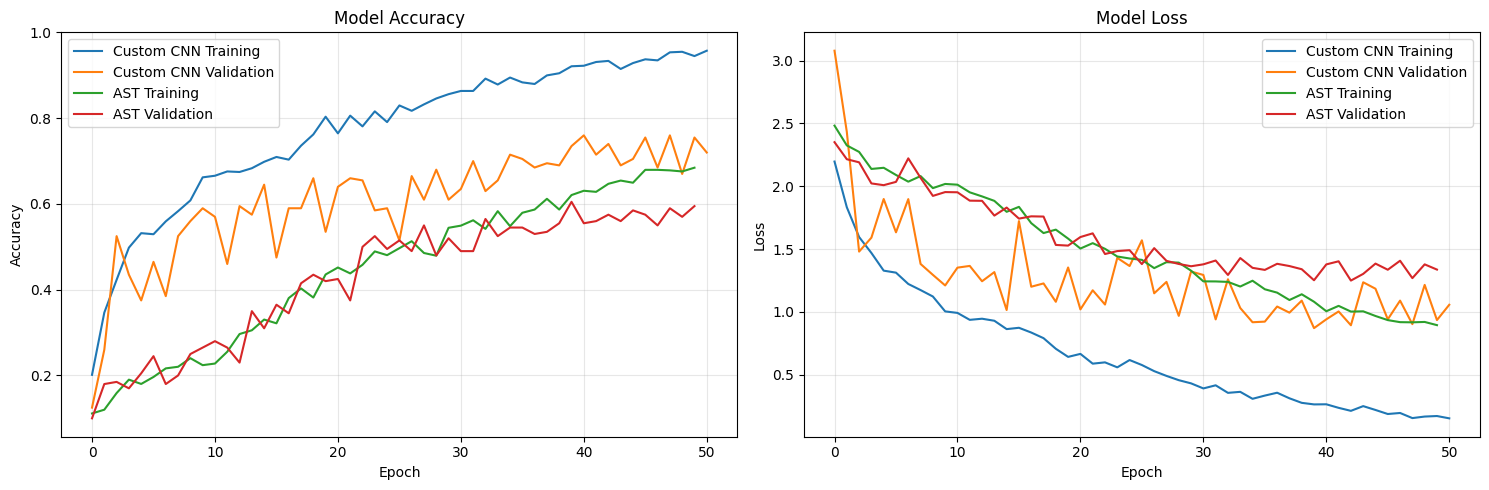

In [ ]:
plt.figure(figsize=(15, 5))

# Accuracy plots
plt.subplot(1, 2, 1)
plt.plot(cnn_history['train_acc'], label='Custom CNN Training')
plt.plot(cnn_history['val_acc'], label='Custom CNN Validation')
plt.plot(ast_history['train_acc'], label='AST Training')
plt.plot(ast_history['val_acc'], label='AST Validation')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.grid(alpha=0.3)

# Loss plots
plt.subplot(1, 2, 2)
plt.plot(cnn_history['train_loss'], label='Custom CNN Training')
plt.plot(cnn_history['val_loss'], label='Custom CNN Validation')
plt.plot(ast_history['train_loss'], label='AST Training')
plt.plot(ast_history['val_loss'], label='AST Validation')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

### 8. Model Comparison and Best Model Selection

In [ ]:
print("\nModel Performance Comparison:")
print(f"Custom CNN Test Accuracy: {cnn_accuracy:.4f}")
print(f"AST Test Accuracy: {ast_accuracy:.4f}")

# Find the best model
if ast_accuracy >= cnn_accuracy:
    best_model_name = "AST"
    best_model = ast_model
    best_preds = ast_preds
    best_targets = ast_targets
    best_accuracy = ast_accuracy
else:
    best_model_name = "Custom CNN"
    best_model = custom_cnn
    best_preds = cnn_preds
    best_targets = cnn_targets
    best_accuracy = cnn_accuracy

print(f"\nBest model: {best_model_name} with {best_accuracy:.4f} accuracy")


Model Performance Comparison:
Custom CNN Test Accuracy: 0.7600
AST Test Accuracy: 0.6050

Best model: Custom CNN with 0.7600 accuracy


### 9. Evaluate Best Model


Detailed Evaluation of Best Model:

Classification Report:
              precision    recall  f1-score   support

       blues       0.81      0.65      0.72        20
   classical       0.79      0.95      0.86        20
     country       0.70      0.70      0.70        20
       disco       0.84      0.80      0.82        20
      hiphop       0.67      0.90      0.77        20
        jazz       0.93      0.65      0.76        20
       metal       0.91      1.00      0.95        20
         pop       0.83      0.75      0.79        20
      reggae       1.00      0.45      0.62        20
        rock       0.48      0.75      0.59        20

    accuracy                           0.76       200
   macro avg       0.80      0.76      0.76       200
weighted avg       0.80      0.76      0.76       200



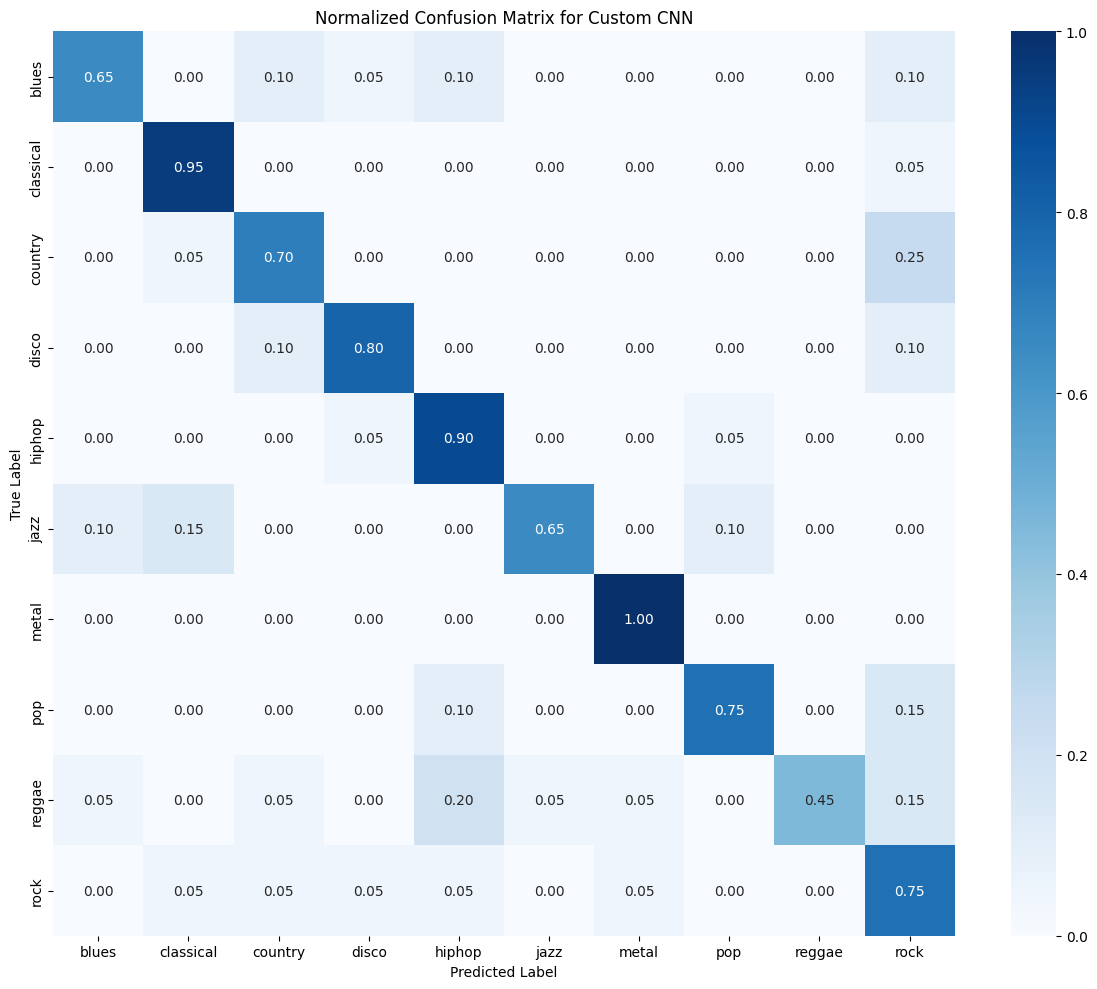

In [ ]:
print("\nDetailed Evaluation of Best Model:")
print("\nClassification Report:")
print(classification_report(best_targets, best_preds, target_names=genres))

# Confusion matrix
plt.figure(figsize=(12, 10))
cm = confusion_matrix(best_targets, best_preds)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

sns.heatmap(
    cm_normalized, 
    annot=True, 
    fmt='.2f', 
    cmap='Blues', 
    xticklabels=genres, 
    yticklabels=genres,
    vmin=0, 
    vmax=1
)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title(f'Normalized Confusion Matrix for {best_model_name}')
plt.tight_layout()
plt.show()

### 10. Class Activation Mapping Visualization (using Grad-CAM)

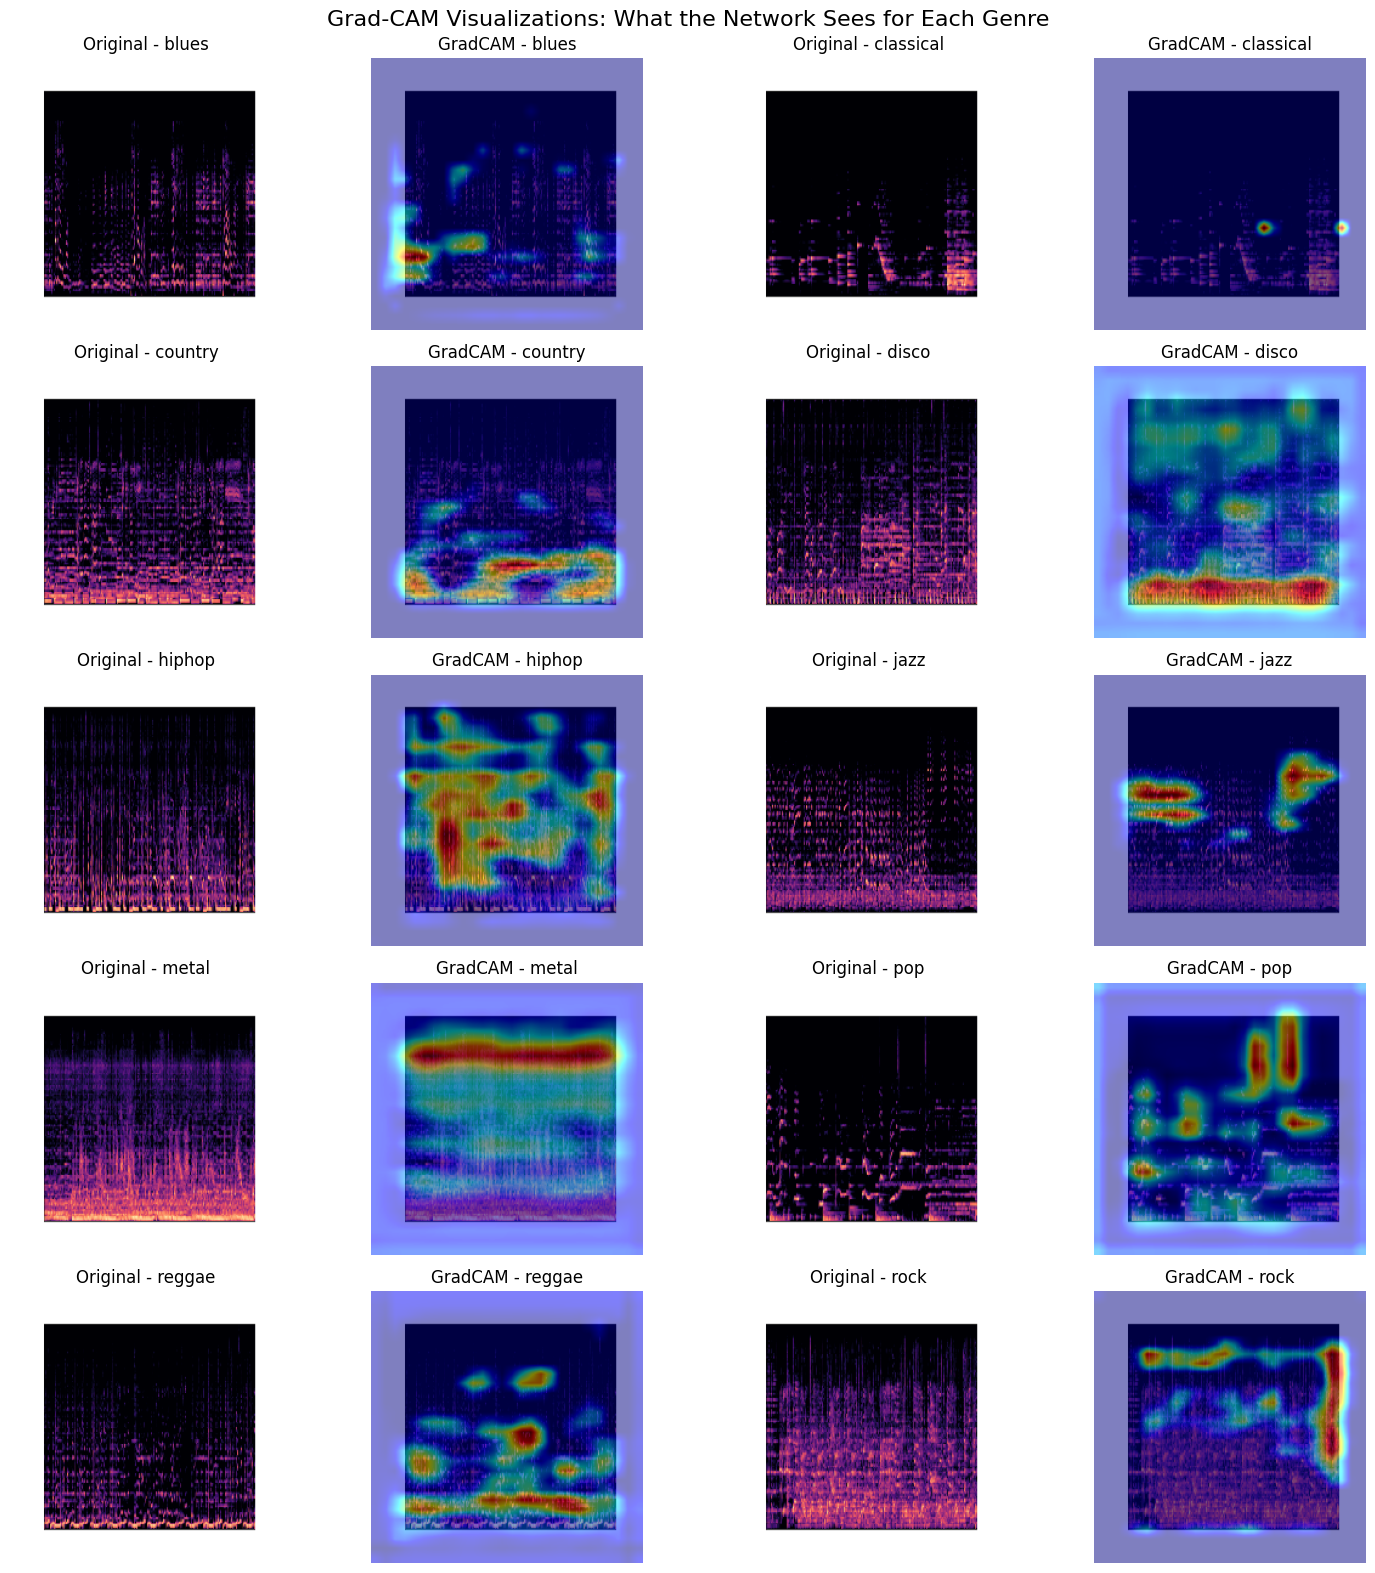

In [ ]:
# Only implemented if the PyTorch Grad-CAM library is installed
try:
    from pytorch_grad_cam import GradCAM
    from pytorch_grad_cam.utils.image import show_cam_on_image
    from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
    
    # Choose layers to visualize
    if best_model_name == "AST":
        # For AST, we can't easily use GradCAM due to its transformer architecture
        print("GradCAM visualization not implemented for transformer architecture")
    else:
        # For Custom CNN
        target_layer = [custom_cnn.conv4[-3]]  # Get the last Conv2d layer
        
        # Initialize the GradCAM object
        cam = GradCAM(model=custom_cnn, target_layers=target_layer)
        
        # Visualize examples for each genre
        plt.figure(figsize=(15, 16))
        for i, genre in enumerate(genres):
            # Find a correctly predicted example
            correct_indices = np.where((cnn_targets == i) & (cnn_preds == i))[0]
            if len(correct_indices) == 0:
                continue
                
            idx = correct_indices[0]
            input_tensor = torch.tensor(X_test[idx]).unsqueeze(0).to(device)
            
            # Create target for the specific class
            targets = [ClassifierOutputTarget(i)]
            
            # Generate heatmap
            grayscale_cam = cam(input_tensor=input_tensor, targets=targets)
            grayscale_cam = grayscale_cam[0, :]
            
            # Convert to RGB for visualization (transpose back to HWC)
            rgb_img = X_test[idx].transpose(1, 2, 0)
            
            # Create visualization
            visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)
            
            # Display original and heatmap
            plt.subplot(5, 4, i*2+1)
            plt.imshow(rgb_img)
            plt.title(f'Original - {genre}')
            plt.axis('off')
            
            plt.subplot(5, 4, i*2+2)
            plt.imshow(visualization)
            plt.title(f'GradCAM - {genre}')
            plt.axis('off')
        
        plt.tight_layout()
        plt.suptitle('Grad-CAM Visualizations: What the Network Sees for Each Genre', fontsize=16)
        plt.subplots_adjust(top=0.95)
        plt.show()
except ImportError:
    print("pytorch-grad-cam not installed. Skipping visualization.")

### 11. Most Confused Genre Pairs

In [ ]:
print("\nMost Confused Genre Pairs:")
confusion = cm_normalized.copy()
np.fill_diagonal(confusion, 0)  # Remove diagonal (correct predictions)
for i in range(len(genres)):
    for j in range(len(genres)):
        if confusion[i, j] > 0.15:  # Show pairs with >15% confusion
            print(f"{genres[i]} confused as {genres[j]}: {confusion[i, j]:.2f}")


Most Confused Genre Pairs:
country confused as rock: 0.25
reggae confused as hiphop: 0.20


In [33]:
print("\nAdvantages of the Models:")
print(f"Custom CNN Accuracy: {cnn_accuracy:.4f}")
print(f"AST Accuracy: {ast_accuracy:.4f}")


Advantages of the Models:
Custom CNN Accuracy: 0.7600
AST Accuracy: 0.6050


Custom CNN Advantages:
- Convolutional architecture suited for capturing local patterns in spectrograms
- Fast training and inference times

AST (Audio Spectrogram Transformer) Advantages:
- Captures global relationships through self-attention
- Better at modeling long-range dependencies in spectrograms
- State-of-the-art architecture for audio classification tasks

# Summary & Discussions

## Task 1 - Observations

The music genre classification with Essentia descriptors demonstrated exceptional performance, particularly with a neural network. The analysis is as follows:

- **Model Performance**:
  - Neural Network achieved perfect test accuracy (100%), significantly outperforming all other models
  - Top three models in cross-validation: Neural Network (83.1%), Logistic Regression (81.4%), and SVM (80.0%)
  - Ensemble approach reached 99.5% accuracy, which confirms the strength of combined models
  - Simpler models performed surprisingly well (Logistic Regression: 90.7%)

- **Discussion**:
  - The perfect test accuracy suggests either exceptionally good feature separation or potential overfitting
  - The strong performance of multiple algorithms suggests Essentia descriptors provide highly discriminative features for genre classification

## Task 2 - 3-second and 30-second features - Observations

The comparison between 30-second and 3-second features have interesting results in music genre classification:

- **Model Performance**:
    - 3-second features achieved better accuracy (85.4%) compared to 30-second features (78.6%)
    - Random Forest was the top-performing model in both approaches
    - Feature importance varied significantly between the two approaches
    - Short-segment features consistently outperformed across different classifiers

- **Discussion**:
    - 3-second features provide better discriminative power for genre classification
    - Short-time features capture important temporal dynamics and transitions that may be averaged out in longer segments
    - The superior performance of shorter segments might be due to local patterns in music being more distinctive for genre identification than global statistics
    - This aligns with human perception, where short musical phrases are often sufficient for genre recognition


## Task 3 - Spectrogram-Based Classification - Observations



The CNN-based approaches to music genre classification using spectrograms displays decent results, with the custom CNN architecture having superior performance over the transformer-based AST model:

- **Model Performance**:
  - Custom CNN achieved 76.0% test accuracy, outperforming the AST model
  - Audio Spectrogram Transformer (AST) reached 60.5% accuracy despite its theoretical advantages
  - Specific genre confusion patterns emerged, particularly country/rock (25%) and reggae/hiphop (20%)
  - The performance gap suggests spectrogram-based classification benefits more from local pattern recognition

- **Discussion**:
  - The superior performance of the simpler CNN architecture highlights that domain-specific design can outperform general-purpose architectures
  - AST's underperformance may possibly be due to insufficient training data for transformer model to leverage the global attention capabilities
  - Genre confusion patterns align with musicological similarities, e.g., country/rock often share instrumentation and structure